In [1]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widget
import os
from omegaconf import DictConfig, OmegaConf, open_dict
from hydra.utils import instantiate



import sys
sys.path.append('../../../')
import sunscc
from sunscc.transforms import *
from sunscc.nb.load import load_from_dir, load_from_dir2, load_from_cfg

# import warnings
# warnings.filterwarnings("error")

%matplotlib inline
# %matplotlib ipympl
# %reload_ext autoreload
# %autoreload 2

# Unite All predictions

In [2]:
from pathlib import Path
import pandas as pd
import pandas as pd
import json
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

kind = 'WithHide'


result_dir = 'results_old_dataset'    # Conservative Dataset, overlapping sunspot groups were removed
                                      # during dataset creation (original submission)
# result_dir = 'results_overlap_only'  # Dataset that only contains overlapping sunspot groups (used in the rebuttal)

# NOT NEEDED ANYMORE
# result_dir = 'results_new_dataset'  # All sunspot groups, with possibility to show 2 in one image (used in the rebuttal)
# result_dir = 'results_filtered'     # Subset of the new_dataset, the groups in overlap_only werre removed (used in the rebuttal)


train_overlap = False
train_overlap_str = 'train_overlap' if train_overlap else 'train_noOverlap'

NoOverlap_filtered = True
NoOverlap_filtered_str = 'Filtered' if NoOverlap_filtered else 'NotFiltered'


img_subname = {'results': train_overlap_str+'_test_All' ,
               'results_old_dataset': train_overlap_str+'_test_noOverlap',
               'results_overlap_only': train_overlap_str+'_test_onlyOverlap',
               'results_filtered': train_overlap_str+'_test_filtered'
              }


run_dirs=[
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run21' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run22' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run23' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run24' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run25' ),
    
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run26' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run27' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run28' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run29' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run30' ),
    
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run31' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run32' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run33' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run34' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run35' ),
    
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run36' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run37' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run38' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run39' ),
    Path('../../../outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run40' ),

]

data_aug_freqs = {}
for i, run_dir in enumerate(run_dirs):
    run_id = int(str(run_dir)[-2:])
    decomposition = str(run_dir).split('_')
    da_freq = decomposition[-4]
    if da_freq not in data_aug_freqs:
        data_aug_freqs[da_freq] = []
    data_aug_freqs[da_freq].append(i)
print(data_aug_freqs)

{'0.0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}


In [3]:
n_bins = 11
bins = np.linspace(0, 1, n_bins, endpoint=True)

angular_excentricity = pd.read_csv(run_dirs[0] / result_dir / 'angular_excentricity.csv' )
angular_excentricity = angular_excentricity.iloc[:, ~angular_excentricity.columns.str.contains('^Unnamed')] 

angular_excentricity.head()

,angular_excentricity
0,0.114704
1,0.254952
2,0.846746
3,0.266586
4,0.431081


In [4]:
huge_dict = {}

with open(run_dirs[0] / result_dir / 'mappers.json', 'r') as f:
    mapper = json.load(f)
    
inverted_mapper = {
                     'inv_c1':   {str(v): k  for k,v in mapper['used_c1'].items() },
                     'inv_c2':   {str(v): k  for k,v in mapper['used_c2'].items() },
                     'inv_c3':   {str(v): k  for k,v in mapper['used_c3'].items() },
                    }
print(mapper)
print(inverted_mapper)

run_ids = [int(str(run_dir)[-2:]) for run_dir in run_dirs]

#code for y1
total_y1_pred = pd.DataFrame()
for i, run_dir in enumerate(run_dirs):
    run_id = int(str(run_dir)[-2:])
    yt_1 = pd.read_csv(run_dir / result_dir / 'y1.csv' )
    yt_1 = yt_1.loc[:, ~yt_1.columns.str.contains('^Unnamed')] 

    if i == 0:
        total_y1_pred["GT"] = yt_1[['y1_true']]

    total_y1_pred[f'run_{run_id}'] =  yt_1['y1_pred']


#code for y2
total_y2_pred = pd.DataFrame()
for i, run_dir in enumerate(run_dirs):
    run_id = int(str(run_dir)[-2:])
    yt_2 = pd.read_csv(run_dir / result_dir/ 'y2.csv' )
    yt_2 = yt_2.loc[:, ~yt_2.columns.str.contains('^Unnamed')] 

    if i == 0:
        total_y2_pred["GT"] = yt_2[['y2_true']]

    total_y2_pred[f'run_{run_id}'] =  yt_2['y2_pred']

#code for y3
total_y3_pred = pd.DataFrame()
for i, run_dir in enumerate(run_dirs):
    run_id = int(str(run_dir)[-2:])
    yt_3 = pd.read_csv(run_dir / result_dir / 'y3.csv' )
    yt_3 = yt_3.loc[:, ~yt_3.columns.str.contains('^Unnamed')] 

    if i == 0:
        total_y3_pred["GT"] = yt_3[['y3_true']]

    total_y3_pred[f'run_{run_id}'] =  yt_3['y3_pred']

    

{'used_c1': {'A': 0, 'B': 1, 'C': 2, 'SuperGroup': 3, 'H': 4}, 'used_c2': {'x': 0, 'r': 1, 'sym': 2, 'asym': 3}, 'used_c3': {'x': 0, 'o': 1, 'frag': 2}}
{'inv_c1': {'0': 'A', '1': 'B', '2': 'C', '3': 'SuperGroup', '4': 'H'}, 'inv_c2': {'0': 'x', '1': 'r', '2': 'sym', '3': 'asym'}, 'inv_c3': {'0': 'x', '1': 'o', '2': 'frag'}}


   GT  run_21  run_22  run_23  run_24  run_25  run_26  run_27  run_28  run_29  \
0   0       1       1       1       1       1       1       1       1       1   
1   3       3       3       3       3       3       3       3       3       3   
2   0       4       4       4       4       0       0       4       4       0   
3   0       0       0       1       1       1       1       0       0       0   
4   1       1       1       2       1       1       1       1       1       1   

   ...  run_34  run_35  run_36  run_37  run_38  run_39  run_40  Rate  \
0  ...       1       1       1       1       1       1       1  0.00   
1  ...       3       3       3       3       3       3       3  1.00   
2  ...       0       1       0       4       4       4       4  0.25   
3  ...       0       1       1       0       1       1       0  0.40   
4  ...       2       2       1       1       1       1       1  0.80   

   angular_distance  Bin  
0         10.323384    1  
1         22.945716    2  

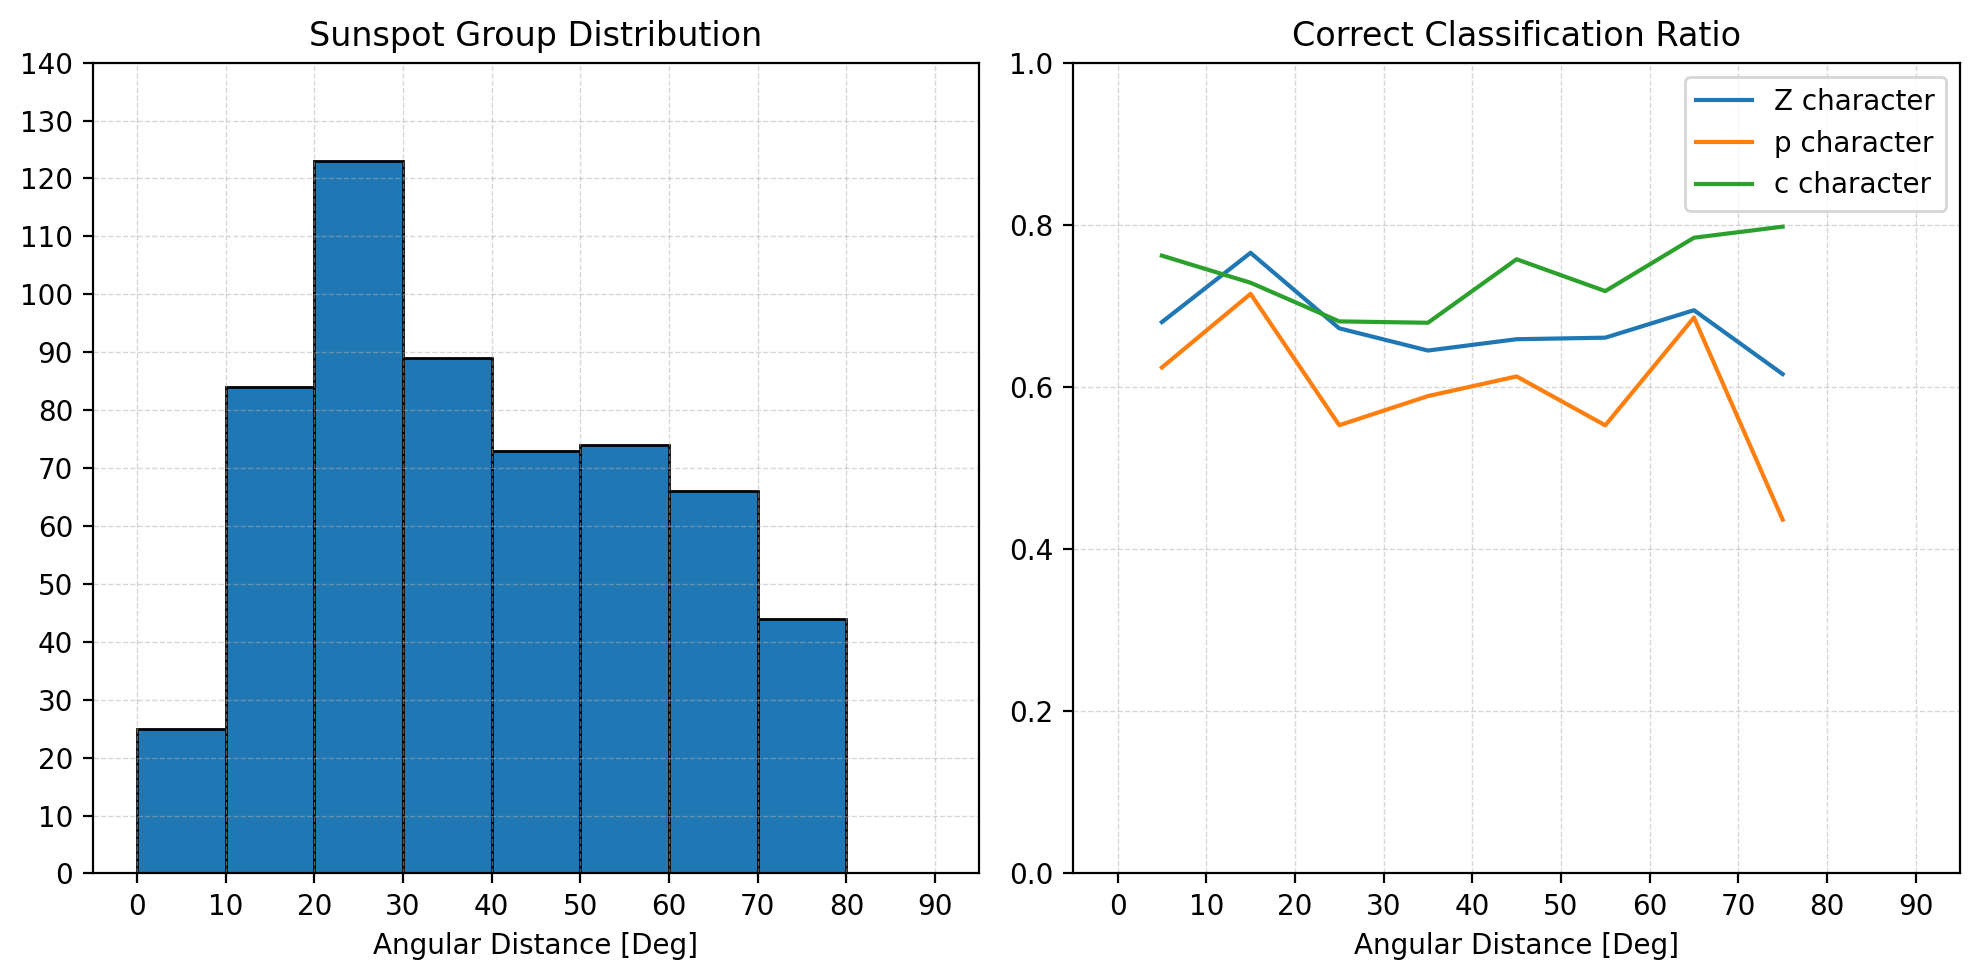

In [5]:
remove_above_80 = True       
step=10
m = 80 if remove_above_80 else 90
bins = list(range(0,m+step,step)) 
b_x = np.array([(bins[i]+ bins[i+1])/2 for i in range(len(bins)-1)])

def count_matching_runs(row):
    gt_value = row['GT']
    matching_runs = [col for col in row.index if col.startswith('run_') and row[col] == gt_value]
    total_runs = sum(col.startswith('run_') for col in row.index)
    
    if total_runs == 0:
        return 0
    
    rate = len(matching_runs) / total_runs
#     rate = len(matching_runs)
    return rate

for k_f, v_f in data_aug_freqs.items():
    freq_run_dirs = [run_dirs[j] for j in v_f]
    
    
    total_y1_pred = pd.DataFrame()
    total_y2_pred = pd.DataFrame()
    total_y3_pred = pd.DataFrame()
    
    for i, run_dir in enumerate(freq_run_dirs):
        run_id = int(str(run_dir)[-2:])

        # get predictions of class 1
        yt_1 = pd.read_csv(run_dir / result_dir / 'y1.csv' )
        yt_1 = yt_1.loc[:, ~yt_1.columns.str.contains('^Unnamed')] 

        # get predictions of class 2
        yt_2 = pd.read_csv(run_dir / result_dir / 'y2.csv' )
        yt_2 = yt_2.loc[:, ~yt_2.columns.str.contains('^Unnamed')]

        # get predictions of class 3
        yt_3 = pd.read_csv(run_dir / result_dir / 'y3.csv' )
        yt_3 = yt_3.loc[:, ~yt_3.columns.str.contains('^Unnamed')]
        
        angular_excentricity = pd.read_csv(run_dirs[0] / result_dir / 'angular_excentricity.csv' )*90
        angular_excentricity = angular_excentricity.iloc[:, ~angular_excentricity.columns.str.contains('^Unnamed')] 

        
        if remove_above_80:      
#             print(yt_1.shape)
            yt_1 = yt_1[angular_excentricity['angular_excentricity'] <= 80]
            yt_2 = yt_2[angular_excentricity['angular_excentricity'] <= 80]
            yt_3 = yt_3[angular_excentricity['angular_excentricity'] <= 80]            
            angular_excentricity = angular_excentricity[angular_excentricity['angular_excentricity'] <= 80]


        if i == 0:
            total_y1_pred["GT"] = yt_1[['y1_true']]
            total_y2_pred["GT"] = yt_2[['y2_true']]
            total_y3_pred["GT"] = yt_3[['y3_true']]
            
        
        total_y1_pred[f'run_{run_id}'] =  yt_1['y1_pred']
        total_y2_pred[f'run_{run_id}'] =  yt_2['y2_pred']
        total_y3_pred[f'run_{run_id}'] =  yt_3['y3_pred']
            
    total_y1_pred['Rate'] = total_y1_pred.apply(count_matching_runs, axis=1)
    total_y2_pred['Rate'] = total_y2_pred.apply(count_matching_runs, axis=1)
    total_y3_pred['Rate'] = total_y3_pred.apply(count_matching_runs, axis=1)

    total_y1_pred['angular_distance'] = angular_excentricity
    total_y2_pred['angular_distance'] = angular_excentricity
    total_y3_pred['angular_distance'] = angular_excentricity

    total_y1_pred['Bin'] = pd.cut(total_y1_pred['angular_distance'], bins=bins, labels=False, right=False)
    total_y2_pred['Bin'] = pd.cut(total_y2_pred['angular_distance'], bins=bins, labels=False, right=False)
    total_y3_pred['Bin'] = pd.cut(total_y3_pred['angular_distance'], bins=bins, labels=False, right=False)
            
    print(total_y1_pred.head())
     
    # Group the DataFrame by 'Bin' and calculate the mean and variance of 'Rate' for each group
    grouped_total_y1_pred = total_y1_pred.groupby('Bin')['Rate'].agg(['mean', 'var', 'std'])
    grouped_total_y2_pred = total_y2_pred.groupby('Bin')['Rate'].agg(['mean', 'var', 'std'])
    grouped_total_y3_pred = total_y3_pred.groupby('Bin')['Rate'].agg(['mean', 'var', 'std'])
    
    grouped_total_y1_pred['Bin_center'] = b_x
    grouped_total_y2_pred['Bin_center'] = b_x
    grouped_total_y3_pred['Bin_center'] = b_x
    
    print(grouped_total_y1_pred)
    
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=200)
    
    n,_,_ =ax[0].hist(angular_excentricity, bins=bins, ec='black', )
    ax[0].set_xlim([-5,95])
    ax[0].set_yticks(np.arange(0,np.max(n)+20,10))
    ax[0].set_xticks(np.arange(0,100,10))
    ax[0].set_xlabel('Angular Distance [Deg]')
    # ax[0].set_ylabel('Count')
    ax[0].set_ylabel('')
    ax[0].set_title('Sunspot Group Distribution')
    ax[0].grid(linestyle='--', linewidth=0.5, alpha=0.5)
    
    g = sns.lineplot(
                data=grouped_total_y1_pred,
                x="Bin_center",
                y='mean',
                label='Z character',
                ax=ax[1],
            )
    g = sns.lineplot(
                data=grouped_total_y2_pred,
                x="Bin_center",
                y='mean',
                label='p character',
                ax=ax[1],
            )
    g = sns.lineplot(
                data=grouped_total_y3_pred,
                x="Bin_center",
                y='mean',
                label='c character',
                ax=ax[1],
            )

    
    ax[1].grid(linestyle='--', linewidth=0.5, alpha=0.5)
    ax[1].set_ylim([0,1])
    ax[1].set_xlim([-5,95])
    ax[1].set_xticks(range(0,90+10,10))
    ax[1].set_xlabel('Angular Distance [Deg]')
    # ax[1].set_ylabel('Correct Classification Ratio')
    ax[1].set_ylabel('')
    ax[1].set_title('Correct Classification Ratio')
    
    fig.tight_layout()  
    

<bound method NDFrame.head of      run_21    run_22    run_23    run_24    run_25    run_26    run_27  \
0  0.680000  0.640000  0.640000  0.640000  0.680000  0.640000  0.720000   
1  0.750000  0.750000  0.809524  0.726190  0.750000  0.738095  0.761905   
2  0.691057  0.674797  0.674797  0.666667  0.650407  0.682927  0.666667   
3  0.640449  0.674157  0.685393  0.674157  0.606742  0.584270  0.584270   
4  0.657534  0.684932  0.712329  0.671233  0.630137  0.643836  0.643836   
5  0.635135  0.702703  0.702703  0.675676  0.608108  0.635135  0.675676   
6  0.742424  0.712121  0.772727  0.636364  0.621212  0.636364  0.727273   
7  0.636364  0.659091  0.636364  0.636364  0.659091  0.568182  0.613636   

     run_28    run_29    run_30    run_31    run_32    run_33    run_34  \
0  0.680000  0.640000  0.760000  0.640000  0.760000  0.640000  0.720000   
1  0.797619  0.773810  0.750000  0.750000  0.761905  0.821429  0.797619   
2  0.650407  0.674797  0.642276  0.682927  0.666667  0.691057  0.6666

,Z,p,c
0.0,0.677076,0.598875,0.726211


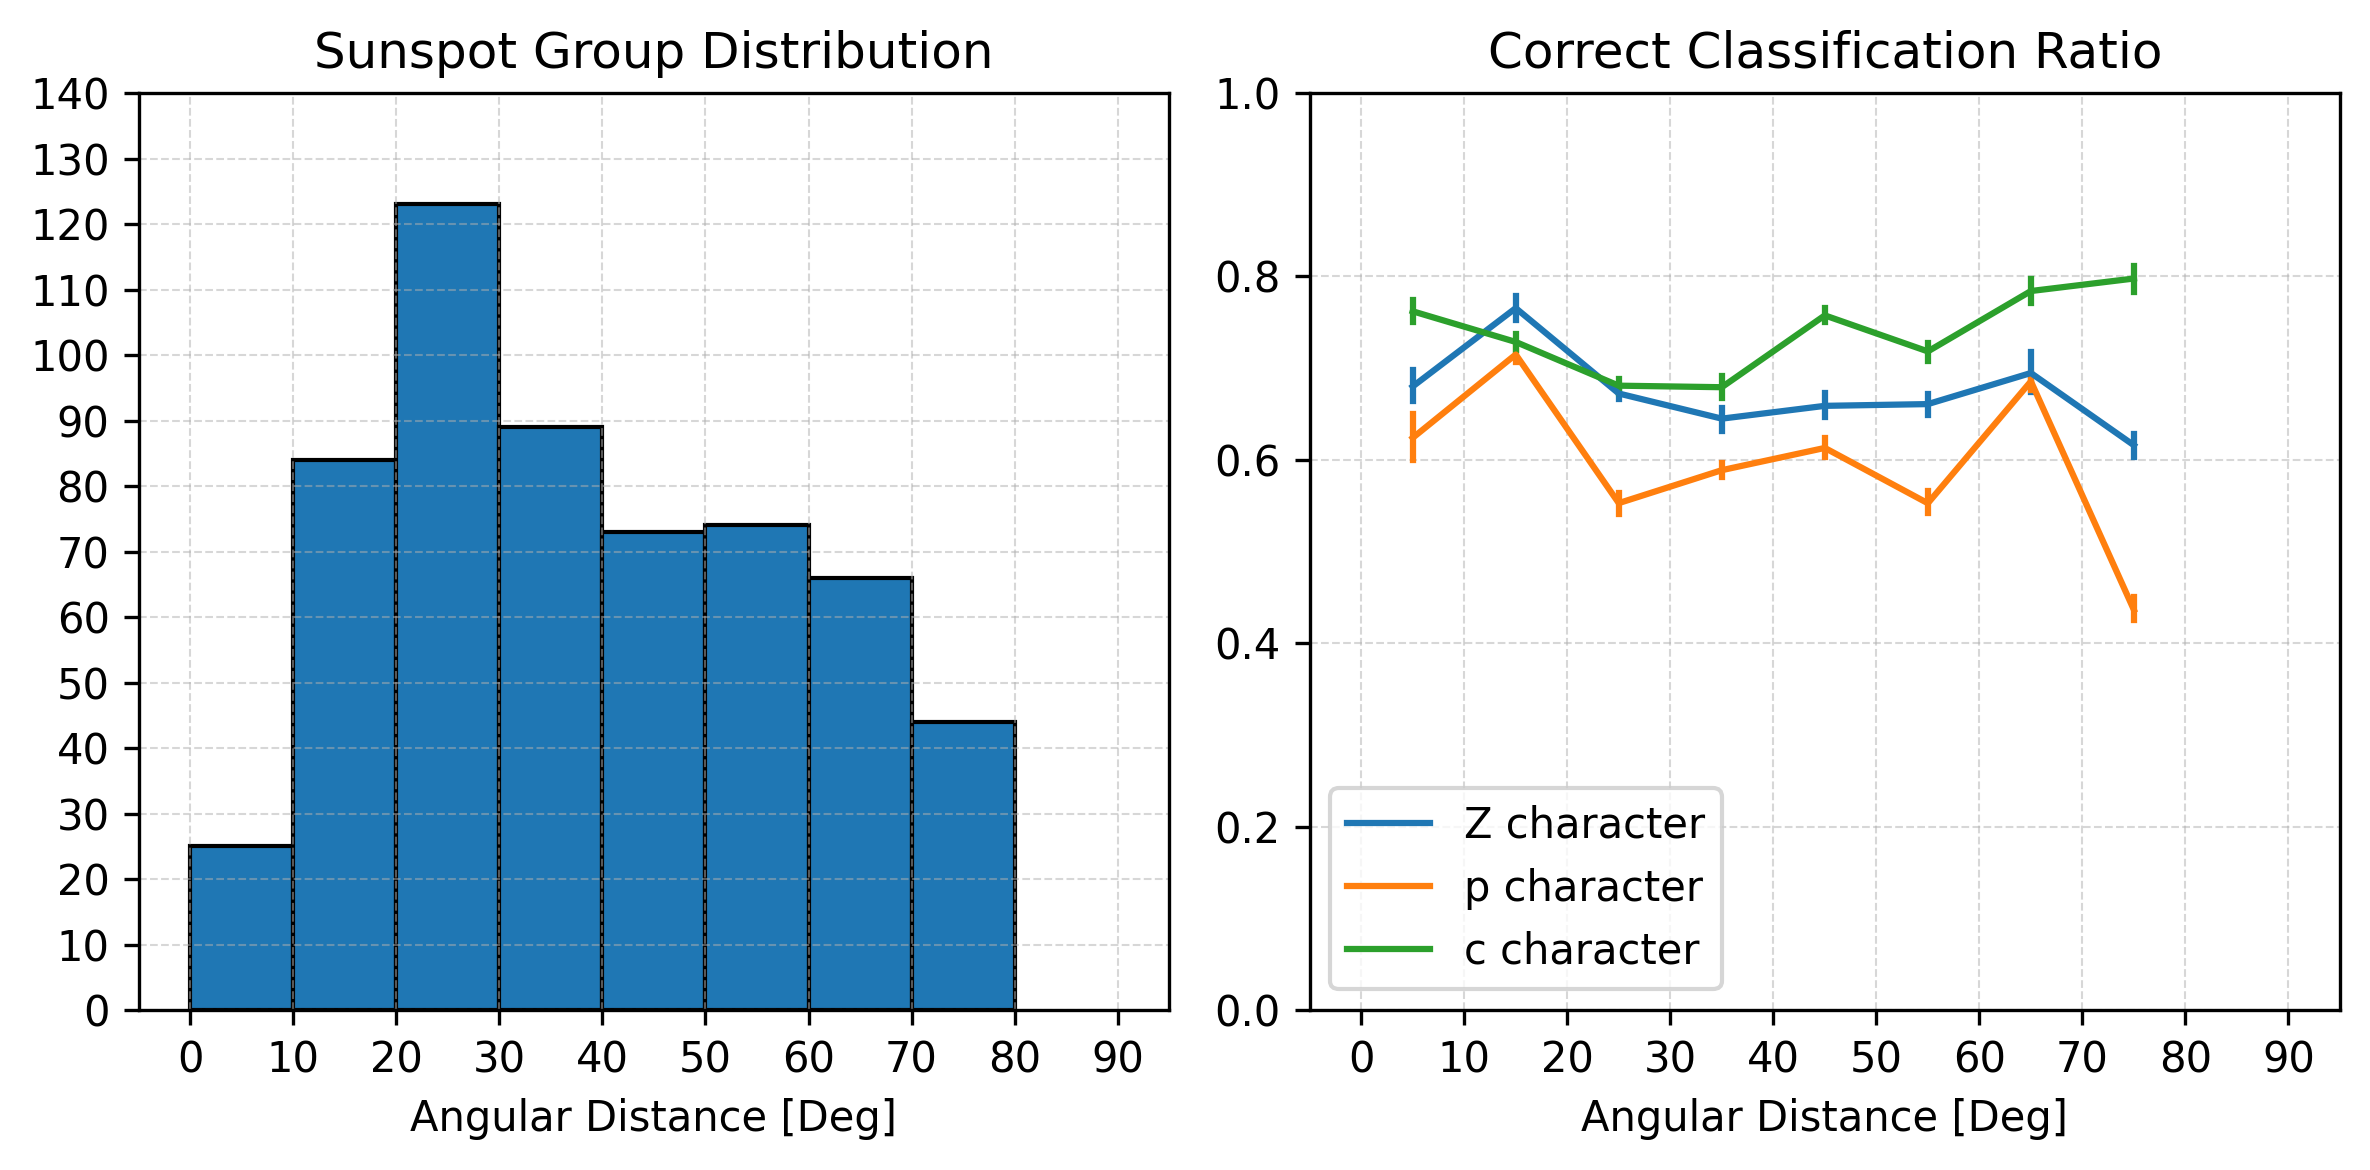

In [6]:
total_correct_c1_y1_pred = pd.DataFrame()
total_correct_c2_y2_pred = pd.DataFrame()
total_correct_c3_y3_pred = pd.DataFrame()

total_ratio_c1_y1_pred = pd.DataFrame()
total_ratio_c2_y2_pred = pd.DataFrame()
total_ratio_c3_y3_pred = pd.DataFrame()

freq_correct_ratios = { c : {str(k_f): [] for k_f in data_aug_freqs.keys()} for c in ["Z","p","c"]}
# print(freq_correct_ratios)

remove_above_80 = True       
step=10
m = 80 if remove_above_80 else 90
bins = list(range(0,m+step,step)) 
b_x = np.array([(bins[i]+ bins[i+1])/2 for i in range(len(bins)-1)])

for k_f, v_f in data_aug_freqs.items():
    freq_run_dirs = [run_dirs[j] for j in v_f]

    for i, run_dir in enumerate(freq_run_dirs):
        run_id = int(str(run_dir)[-2:])

        # get predictions of class 1
        yt_1 = pd.read_csv(run_dir / result_dir / 'y1.csv' )
        yt_1 = yt_1.loc[:, ~yt_1.columns.str.contains('^Unnamed')] 

        # get predictions of class 2
        yt_2 = pd.read_csv(run_dir / result_dir / 'y2.csv' )
        yt_2 = yt_2.loc[:, ~yt_2.columns.str.contains('^Unnamed')]

        # get predictions of class 3
        yt_3 = pd.read_csv(run_dir / result_dir / 'y3.csv' )
        yt_3 = yt_3.loc[:, ~yt_3.columns.str.contains('^Unnamed')]
        
        angular_excentricity = pd.read_csv(run_dirs[0] / result_dir / 'angular_excentricity.csv' )*90
        angular_excentricity = angular_excentricity.iloc[:, ~angular_excentricity.columns.str.contains('^Unnamed')] 

        
        if remove_above_80:      
#             print(yt_1.shape)
            yt_1 = yt_1[angular_excentricity['angular_excentricity'] <= 80]
            yt_2 = yt_2[angular_excentricity['angular_excentricity'] <= 80]
            yt_3 = yt_3[angular_excentricity['angular_excentricity'] <= 80]            
            angular_excentricity = angular_excentricity[angular_excentricity['angular_excentricity'] <= 80]



        if i == 0:
            total_correct_c1_y1_pred["GT"] = yt_1[['y1_true']]
            total_correct_c2_y2_pred["GT"] = yt_2[['y2_true']]
            total_correct_c3_y3_pred["GT"] = yt_3[['y3_true']]


        # compute the ratio of correct prediction class 1
        correct_c1 = yt_1['y1_true'] == yt_1['y1_pred']
        correct_c1_ang = angular_excentricity[correct_c1]
        wrong_c1 = yt_1['y1_true'] != yt_1['y1_pred']
        wrong_c1_ang = angular_excentricity[wrong_c1]

        bins_c_c1 = np.histogram(correct_c1_ang.to_numpy(), bins=bins)[0]
        bins_w_c1 = np.histogram(wrong_c1_ang.to_numpy(), bins=bins)[0]

        ratio_c1 = bins_c_c1 / (bins_c_c1 + bins_w_c1)
        total_ratio_c1_y1_pred[f'run_{run_id}'] =  ratio_c1

        # compute the ratio of correct prediction class 2
        correct_c2 = yt_2['y2_true'] == yt_2['y2_pred']
        correct_c2_ang = angular_excentricity[correct_c2]
        wrong_c2 = yt_2['y2_true'] != yt_2['y2_pred']
        wrong_c2_ang = angular_excentricity[wrong_c2]

        bins_c_c2 = np.histogram(correct_c2_ang.to_numpy(), bins=bins)[0]
        bins_w_c2 = np.histogram(wrong_c2_ang.to_numpy(), bins=bins)[0]

        ratio_c2 = bins_c_c2 / (bins_c_c2 + bins_w_c2)
        total_ratio_c2_y2_pred[f'run_{run_id}'] =  ratio_c2

        # compute the ratio of correct prediction class 3
        correct_c3 = yt_3['y3_true'] == yt_3['y3_pred']
        correct_c3_ang = angular_excentricity[correct_c3]
        wrong_c3 = yt_3['y3_true'] != yt_3['y3_pred']
        wrong_c3_ang = angular_excentricity[wrong_c3]

        bins_c_c3 = np.histogram(correct_c3_ang.to_numpy(), bins=bins)[0]
        bins_w_c3 = np.histogram(wrong_c3_ang.to_numpy(), bins=bins)[0]

        ratio_c3 = bins_c_c3 / (bins_c_c3 + bins_w_c3)
        total_ratio_c3_y3_pred[f'run_{run_id}'] =  ratio_c3
        
        #################
        c1_ratio_tot = correct_c1.sum()/correct_c1.shape[0]
        c2_ratio_tot = correct_c2.sum()/correct_c2.shape[0]
        c3_ratio_tot = correct_c3.sum()/correct_c3.shape[0]
        
        freq_correct_ratios["Z"][str(k_f)].append(c1_ratio_tot)
        freq_correct_ratios["p"][str(k_f)].append(c2_ratio_tot)
        freq_correct_ratios["c"][str(k_f)].append(c3_ratio_tot)
        #################

    
    total_ratio_c1_y1_pred.transpose()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=300)

    n,_,_ =ax[0].hist(angular_excentricity, bins=bins, ec='black', )
    ax[0].set_xlim([-5,95])
    ax[0].set_yticks(np.arange(0,np.max(n)+20,10))
    ax[0].set_xticks(np.arange(0,100,10))
    ax[0].set_xlabel('Angular Distance [Deg]')
    # ax[0].set_ylabel('Count')
    ax[0].set_ylabel('')
    ax[0].set_title('Sunspot Group Distribution')
    ax[0].grid(linestyle='--', linewidth=0.5, alpha=0.5)

    #code for Z character
    print(total_ratio_c1_y1_pred.head)
    df = total_ratio_c1_y1_pred.transpose()
    col_dict = dict(zip(df.columns, b_x))
    df = df.rename(columns=col_dict)
    melted_df = pd.melt(df, var_name='Bin', value_name='Accuracy')
#     bin_means = melted_df.groupby('Bin').mean().reset_index()
    bin_means = melted_df
    g = sns.lineplot(
                    data=bin_means,
                    x="Bin",
                    y='Accuracy',
                    label='Z character',
                    ax=ax[1],
#                 err_style='band',
                err_style='bars',
                )
    # code for p character
    df = total_ratio_c2_y2_pred.transpose()
    col_dict = dict(zip(df.columns, b_x))
    df = df.rename(columns=col_dict)
    melted_df = pd.melt(df, var_name='Bin', value_name='Accuracy')
#     bin_means = melted_df.groupby('Bin').mean().reset_index()
    bin_means = melted_df
    g = sns.lineplot(
                    data=bin_means,
                    x="Bin",
                    y='Accuracy',
                    label='p character',
                    ax=ax[1],
#                 err_style='band',
                err_style='bars',
                )
    # code for c character
    df = total_ratio_c3_y3_pred.transpose()
    col_dict = dict(zip(df.columns, b_x))
    df = df.rename(columns=col_dict)
    melted_df = pd.melt(df, var_name='Bin', value_name='Accuracy')
#     bin_means = melted_df.groupby('Bin').mean().reset_index()
    bin_means = melted_df
    g = sns.lineplot(

                    data=bin_means,
                    x="Bin",
                    y='Accuracy',
                    label='c character',
                    ax=ax[1],
#                 err_style='band',
                err_style='bars',
                )

    ax[1].grid(linestyle='--', linewidth=0.5, alpha=0.5)
    ax[1].set_ylim([0,1])
    ax[1].set_xlim([-5,95])
    ax[1].set_xticks(range(0,90+10,10))
    ax[1].set_xlabel('Angular Distance [Deg]')
    # ax[1].set_ylabel('Correct Classification Ratio')
    ax[1].set_ylabel('')
    ax[1].set_title('Correct Classification Ratio')

    ax[1].legend(loc='lower left')

    fig.tight_layout()


for k1, v1 in freq_correct_ratios.items():
    print(k1)
    for k2, v2 in v1.items():
#         print(f'\t{k2}: {np.mean(v2)}')
        freq_correct_ratios[k1][k2] = np.mean(v2)
        
    
pd.DataFrame(freq_correct_ratios)
  

<bound method NDFrame.head of      run_21    run_22    run_23    run_24    run_25    run_26    run_27  \
0  0.680000  0.640000  0.640000  0.640000  0.680000  0.640000  0.720000   
1  0.750000  0.750000  0.809524  0.726190  0.750000  0.738095  0.761905   
2  0.691057  0.674797  0.674797  0.666667  0.650407  0.682927  0.666667   
3  0.640449  0.674157  0.685393  0.674157  0.606742  0.584270  0.584270   
4  0.657534  0.684932  0.712329  0.671233  0.630137  0.643836  0.643836   
5  0.635135  0.702703  0.702703  0.675676  0.608108  0.635135  0.675676   
6  0.742424  0.712121  0.772727  0.636364  0.621212  0.636364  0.727273   
7  0.636364  0.659091  0.636364  0.636364  0.659091  0.568182  0.613636   

     run_28    run_29    run_30    run_31    run_32    run_33    run_34  \
0  0.680000  0.640000  0.760000  0.640000  0.760000  0.640000  0.720000   
1  0.797619  0.773810  0.750000  0.750000  0.761905  0.821429  0.797619   
2  0.650407  0.674797  0.642276  0.682927  0.666667  0.691057  0.6666

,Z,p,c
0.0,0.677076,0.598875,0.726211


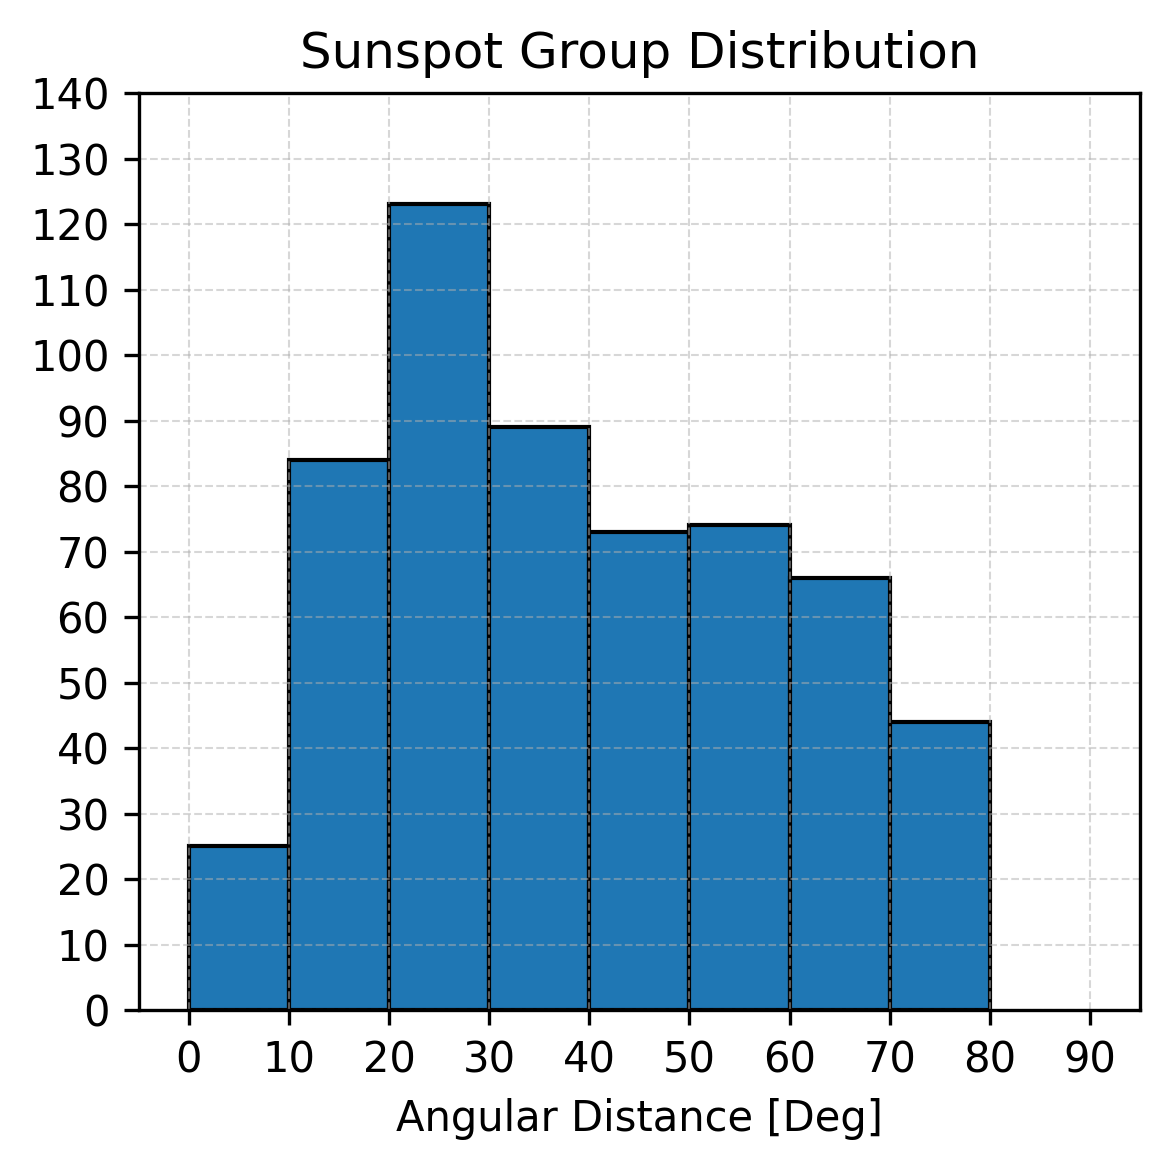

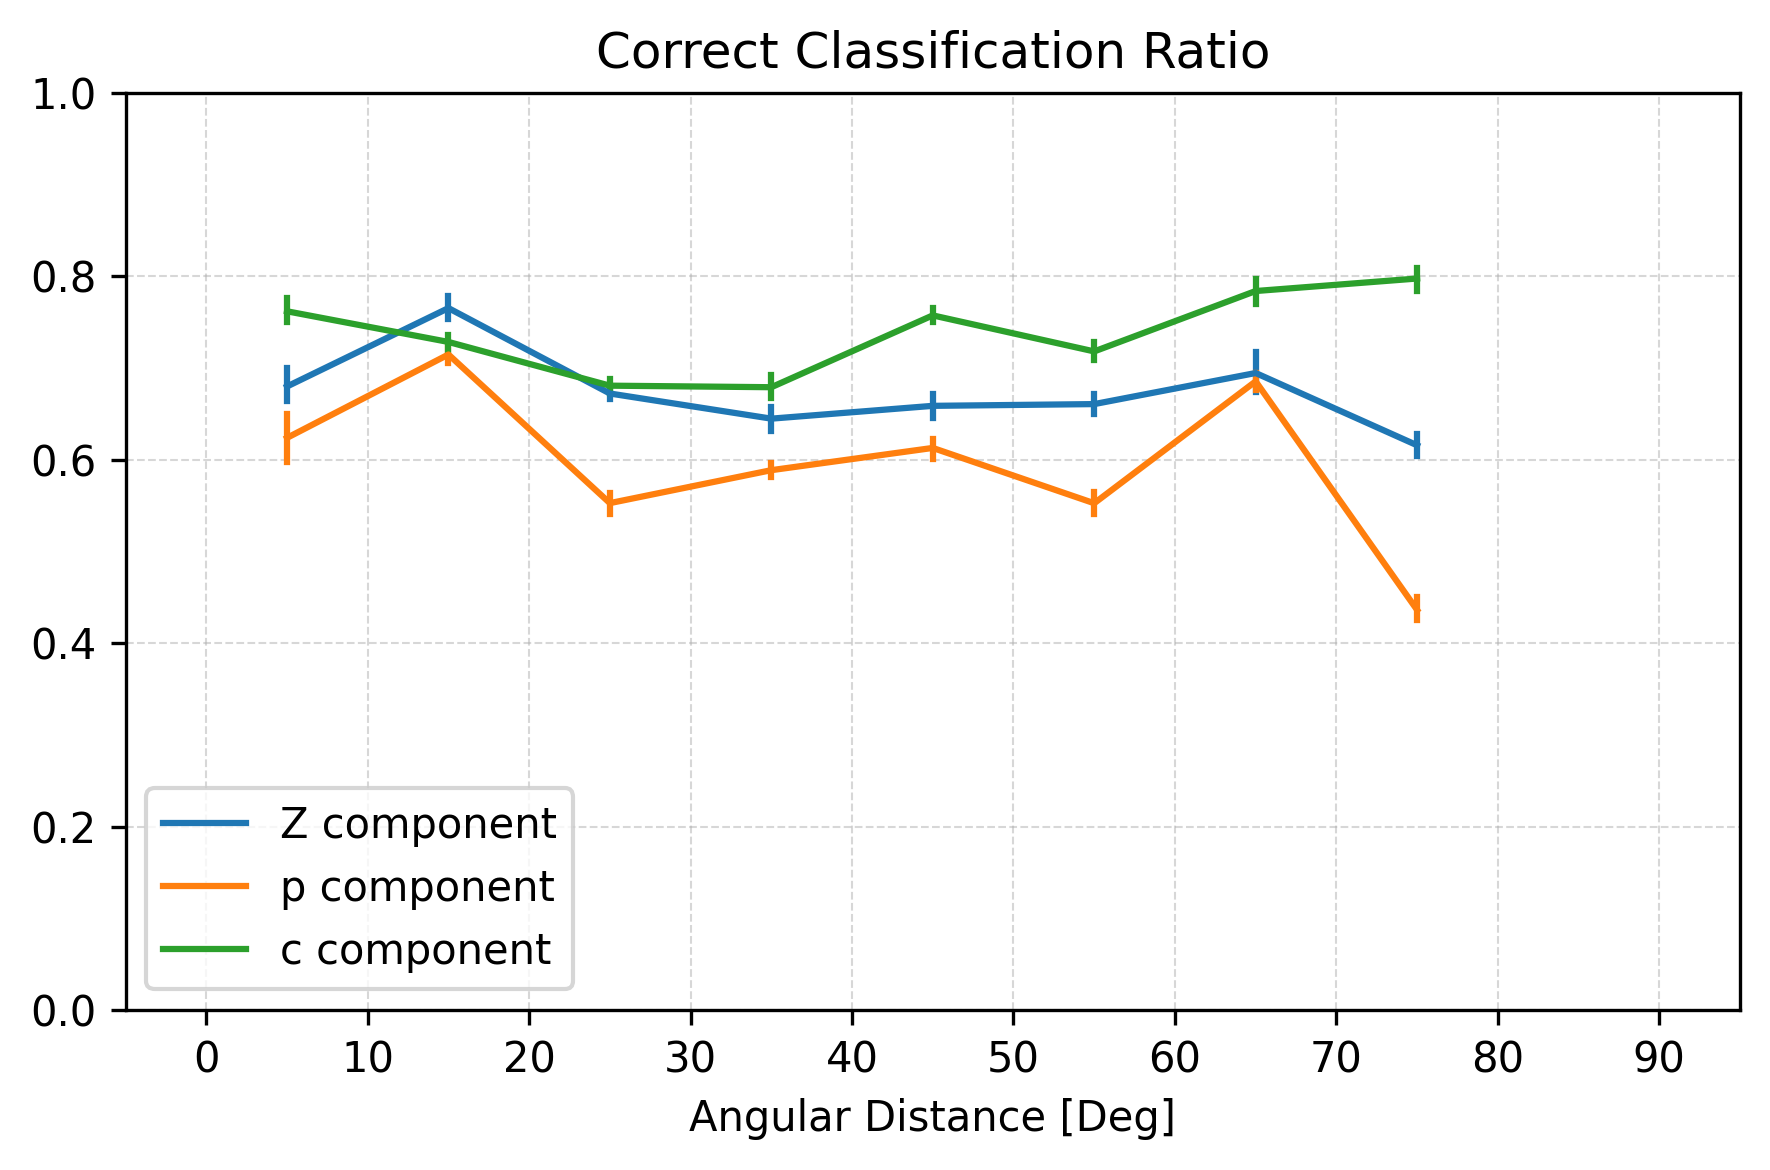

In [7]:
total_correct_c1_y1_pred = pd.DataFrame()
total_correct_c2_y2_pred = pd.DataFrame()
total_correct_c3_y3_pred = pd.DataFrame()

total_ratio_c1_y1_pred = pd.DataFrame()
total_ratio_c2_y2_pred = pd.DataFrame()
total_ratio_c3_y3_pred = pd.DataFrame()

freq_correct_ratios = { c : {str(k_f): [] for k_f in data_aug_freqs.keys()} for c in ["Z","p","c"]}
# print(freq_correct_ratios)

remove_above_80 = True       
step=10
m = 80 if remove_above_80 else 90
bins = list(range(0,m+step,step)) 
b_x = np.array([(bins[i]+ bins[i+1])/2 for i in range(len(bins)-1)])

for k_f, v_f in data_aug_freqs.items():
    freq_run_dirs = [run_dirs[j] for j in v_f]

    for i, run_dir in enumerate(freq_run_dirs):
        run_id = int(str(run_dir)[-2:])

        # get predictions of class 1
        yt_1 = pd.read_csv(run_dir / result_dir / 'y1.csv' )
        yt_1 = yt_1.loc[:, ~yt_1.columns.str.contains('^Unnamed')] 

        # get predictions of class 2
        yt_2 = pd.read_csv(run_dir / result_dir / 'y2.csv' )
        yt_2 = yt_2.loc[:, ~yt_2.columns.str.contains('^Unnamed')]

        # get predictions of class 3
        yt_3 = pd.read_csv(run_dir / result_dir / 'y3.csv' )
        yt_3 = yt_3.loc[:, ~yt_3.columns.str.contains('^Unnamed')]
        
        angular_excentricity = pd.read_csv(run_dirs[0] / result_dir / 'angular_excentricity.csv' )*90
        angular_excentricity = angular_excentricity.iloc[:, ~angular_excentricity.columns.str.contains('^Unnamed')] 

        
        if remove_above_80:      
            yt_1 = yt_1[angular_excentricity['angular_excentricity'] <= 80]
            yt_2 = yt_2[angular_excentricity['angular_excentricity'] <= 80]
            yt_3 = yt_3[angular_excentricity['angular_excentricity'] <= 80]            
            angular_excentricity = angular_excentricity[angular_excentricity['angular_excentricity'] <= 80]

        if i == 0:
            total_correct_c1_y1_pred["GT"] = yt_1[['y1_true']]
            total_correct_c2_y2_pred["GT"] = yt_2[['y2_true']]
            total_correct_c3_y3_pred["GT"] = yt_3[['y3_true']]


        # compute the ratio of correct prediction class 1
        correct_c1 = yt_1['y1_true'] == yt_1['y1_pred']
        correct_c1_ang = angular_excentricity[correct_c1]
        wrong_c1 = yt_1['y1_true'] != yt_1['y1_pred']
        wrong_c1_ang = angular_excentricity[wrong_c1]


        bins_c_c1 = np.histogram(correct_c1_ang.to_numpy(), bins=bins)[0]
        bins_w_c1 = np.histogram(wrong_c1_ang.to_numpy(), bins=bins)[0]

        ratio_c1 = bins_c_c1 / (bins_c_c1 + bins_w_c1)
        total_ratio_c1_y1_pred[f'run_{run_id}'] =  ratio_c1

        # compute the ratio of correct prediction class 2
        correct_c2 = yt_2['y2_true'] == yt_2['y2_pred']
        correct_c2_ang = angular_excentricity[correct_c2]
        wrong_c2 = yt_2['y2_true'] != yt_2['y2_pred']
        wrong_c2_ang = angular_excentricity[wrong_c2]

        bins_c_c2 = np.histogram(correct_c2_ang.to_numpy(), bins=bins)[0]
        bins_w_c2 = np.histogram(wrong_c2_ang.to_numpy(), bins=bins)[0]

        ratio_c2 = bins_c_c2 / (bins_c_c2 + bins_w_c2)
        total_ratio_c2_y2_pred[f'run_{run_id}'] =  ratio_c2

        # compute the ratio of correct prediction class 3
        correct_c3 = yt_3['y3_true'] == yt_3['y3_pred']
        correct_c3_ang = angular_excentricity[correct_c3]
        wrong_c3 = yt_3['y3_true'] != yt_3['y3_pred']
        wrong_c3_ang = angular_excentricity[wrong_c3]

        bins_c_c3 = np.histogram(correct_c3_ang.to_numpy(), bins=bins)[0]
        bins_w_c3 = np.histogram(wrong_c3_ang.to_numpy(), bins=bins)[0]

        ratio_c3 = bins_c_c3 / (bins_c_c3 + bins_w_c3)
        total_ratio_c3_y3_pred[f'run_{run_id}'] =  ratio_c3
        
        #################
        c1_ratio_tot = correct_c1.sum()/correct_c1.shape[0]
        c2_ratio_tot = correct_c2.sum()/correct_c2.shape[0]
        c3_ratio_tot = correct_c3.sum()/correct_c3.shape[0]
        
        freq_correct_ratios["Z"][str(k_f)].append(c1_ratio_tot)
        freq_correct_ratios["p"][str(k_f)].append(c2_ratio_tot)
        freq_correct_ratios["c"][str(k_f)].append(c3_ratio_tot)
        #################


    total_ratio_c1_y1_pred.transpose()


    fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
    
    n,_,_ =ax1.hist(angular_excentricity, bins=bins, ec='black', )
    ax1.set_xlim([-5,95])
    ax1.set_yticks(np.arange(0,np.max(n)+20,10))
    ax1.set_xticks(np.arange(0,100,10))
    ax1.set_xlabel('Angular Distance [Deg]')
    # ax1.set_ylabel('Count')
    ax1.set_ylabel('')
    ax1.set_title('Sunspot Group Distribution')
    ax1.grid(linestyle='--', linewidth=0.5, alpha=0.5)
    fig1.tight_layout()
    # plt.savefig(f"rebuttal_Hist&Accuracy_{kind}_{NoOverlap_filtered_str}_{img_subname[result_dir]}_histogram.pdf", format="pdf", bbox_inches="tight")
    fig1.show()

    
    fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), dpi=300)
    
    #code for Z character
    print(total_ratio_c1_y1_pred.head)
    df = total_ratio_c1_y1_pred.transpose()
    col_dict = dict(zip(df.columns, b_x))
    df = df.rename(columns=col_dict)
    melted_df = pd.melt(df, var_name='Bin', value_name='Accuracy')
#     bin_means = melted_df.groupby('Bin').mean().reset_index()
    bin_means = melted_df
    g = sns.lineplot(
                    data=bin_means,
                    x="Bin",
                    y='Accuracy',
                    label='Z component',
                    ax=ax2,
#                 err_style='band',
                err_style='bars',
                )
    # code for p character
    df = total_ratio_c2_y2_pred.transpose()
    col_dict = dict(zip(df.columns, b_x))
    df = df.rename(columns=col_dict)
    melted_df = pd.melt(df, var_name='Bin', value_name='Accuracy')
#     bin_means = melted_df.groupby('Bin').mean().reset_index()
    bin_means = melted_df
    g = sns.lineplot(
                    data=bin_means,
                    x="Bin",
                    y='Accuracy',
                    label='p component',
                    ax=ax2,
#                 err_style='band',
                err_style='bars',
                )
    # code for c character
    df = total_ratio_c3_y3_pred.transpose()
    col_dict = dict(zip(df.columns, b_x))
    df = df.rename(columns=col_dict)
    melted_df = pd.melt(df, var_name='Bin', value_name='Accuracy')
#     bin_means = melted_df.groupby('Bin').mean().reset_index()
    bin_means = melted_df
    g = sns.lineplot(

                    data=bin_means,
                    x="Bin",
                    y='Accuracy',
                    label='c component',
                    ax=ax2,
#                 err_style='band',
                err_style='bars',
                )

    ax2.grid(linestyle='--', linewidth=0.5, alpha=0.5)
    ax2.set_ylim([0,1])
    ax2.set_xlim([-5,95])
    ax2.set_xticks(range(0,90+10,10))
    ax2.set_xlabel('Angular Distance [Deg]')
    # ax2.set_ylabel('Correct Classification Ratio')
    ax2.set_ylabel('')
    ax2.set_title('Correct Classification Ratio')

    ax2.legend(loc='lower left')
    fig2.tight_layout()
    # plt.savefig(f"rebuttal_Hist&Accuracy_{kind}_{NoOverlap_filtered_str}_{img_subname[result_dir]}_accuraciesErrorBars.pdf", format="pdf", bbox_inches="tight")
    fig2.show()

for k1, v1 in freq_correct_ratios.items():
    print(k1)
    for k2, v2 in v1.items():
#         print(f'\t{k2}: {np.mean(v2)}')
        freq_correct_ratios[k1][k2] = np.mean(v2)
        
    
pd.DataFrame(freq_correct_ratios)
  

# Majority vote

In [8]:
"""
Code to parse sklearn classification_report
Original: https://gist.github.com/julienr/6b9b9a03bd8224db7b4f
Modified to work with Python 3 and classification report averages
"""

import sys
import collections

def parse_classification_report(clfreport):
    """
    Parse a sklearn classification report into a dict keyed by class name
    and containing a tuple (precision, recall, fscore, support) for each class
    """
    lines = clfreport.split('\n')
    # Remove empty lines
    lines = list(filter(lambda l: not len(l.strip()) == 0, lines))
    lines=[s for s in lines if 'accuracy' not in s]
    
    # Starts with a header, then score for each class and finally an average
    header = lines[0]
    cls_lines = lines[1:-1]
    avg_line = lines[-1]

    assert header.split() == ['precision', 'recall', 'f1-score', 'support']
    assert avg_line.split()[1] == 'avg'

    # We cannot simply use split because class names can have spaces. So instead
    # figure the width of the class field by looking at the indentation of the
    # precision header
    cls_field_width = len(header) - len(header.lstrip())
    # Now, collect all the class names and score in a dict
    def parse_line(l):
        """Parse a line of classification_report"""
        cls_name = l[:cls_field_width].strip()
        precision, recall, fscore, support = l[cls_field_width:].split()
        precision = float(precision)
        recall = float(recall)
        fscore = float(fscore)
        support = int(support)
        return (cls_name, precision, recall, fscore, support)

    data = collections.OrderedDict()
    for l in cls_lines:
        ret = parse_line(l)
        cls_name = ret[0]
        scores = ret[1:]
        data[cls_name] = scores

    # average
    data['avg'] = parse_line(avg_line)[1:]

    return data

def report_to_latex_table(data):
    avg_split = False
    out = ""
    out += "\\begin{table}\n"
    out += "\\caption{Latex Table from Classification Report}\n"
    out += "\\label{table:classification:report}\n"
    out += "\\centering\n"
    out += "\\begin{tabular}{c | c c c r}\n"
    out += "Class & Precision & Recall & F-score & Support\\\\\n"
    out += "\\midrule\n"
    for cls, scores in data.items():
        if 'micro' in cls:
            out += "\\midrule\n"
        out += cls + " & " + " & ".join([str(s) for s in scores])
        out += "\\\\\n"
    out += "\\end{tabular}\n"
    out += "\\end{table}"
    return out

def print_to_file(string, filename):
    with open(filename, 'w') as f:
        f.write(string)

The next cell displays the confusion matrices for each McIntosh component (Z,p,c)

The Corresponding metrics used in Table 6 as well as Tables in Appendix E of published paper (especially F1-score) are also shown under the weighted average metric in the text tables.

Data Augmentation Frequency: 0.0
Z
              precision    recall  f1-score   support

           0       0.50      0.80      0.61        64
           1       0.57      0.65      0.61        78
           2       0.59      0.47      0.53       120
           3       0.86      0.71      0.77       160
           4       0.78      0.79      0.79       158

    accuracy                           0.68       580
   macro avg       0.66      0.68      0.66       580
weighted avg       0.70      0.68      0.69       580

p
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       142
           1       0.24      0.58      0.34        55
           2       0.73      0.52      0.61       208
           3       0.66      0.58      0.61       175

    accuracy                           0.60       580
   macro avg       0.59      0.61      0.58       580
weighted avg       0.66      0.60      0.62       580

c
              precision    recall  f1

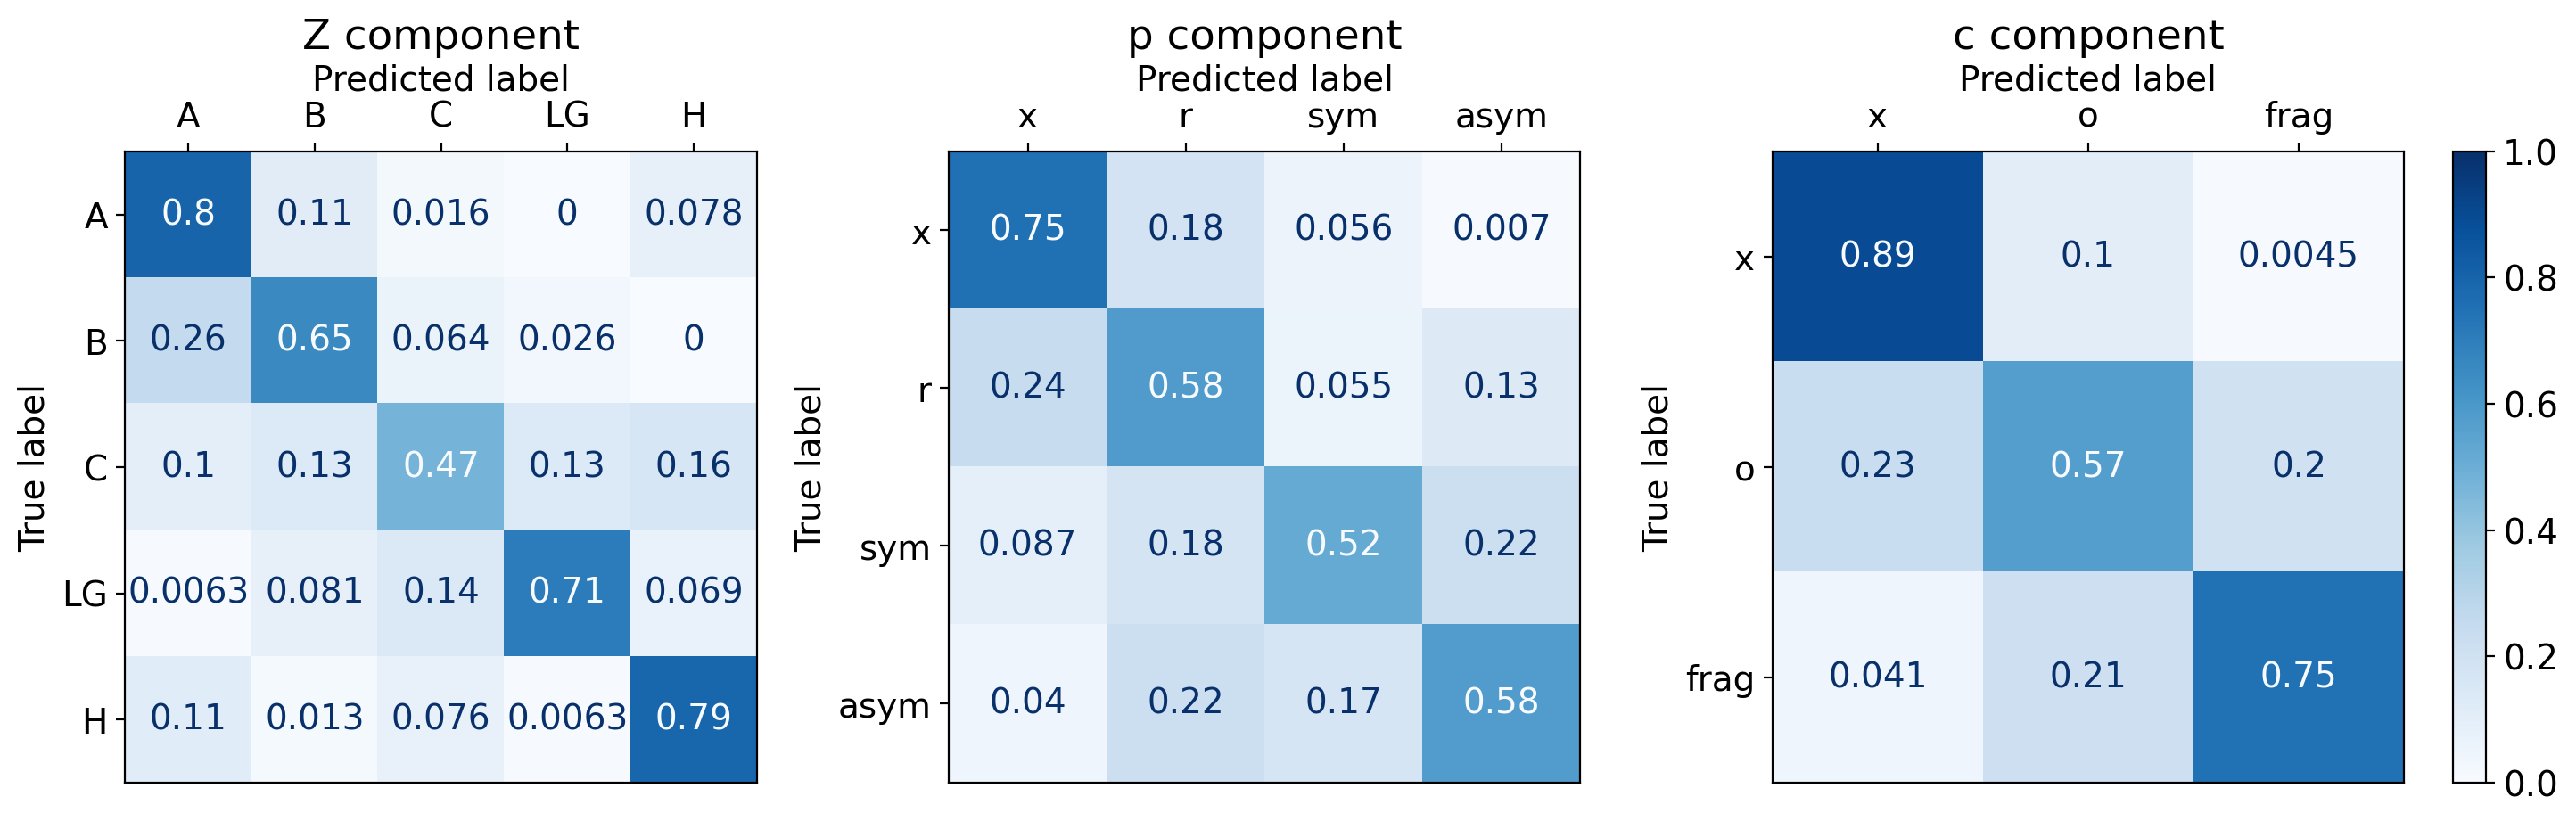

In [9]:
for k_f, v_f in data_aug_freqs.items():
    freq_run_dirs = [run_dirs[j] for j in v_f]
    
    #code for y1
    total_y1_pred = pd.DataFrame()
    for i, run_dir in enumerate(freq_run_dirs):
        run_id = int(str(run_dir)[-2:])
        yt_1 = pd.read_csv(run_dir / result_dir / 'y1.csv' )
        yt_1 = yt_1.loc[:, ~yt_1.columns.str.contains('^Unnamed')] 

        if i == 0:
            total_y1_pred["GT"] = yt_1[['y1_true']]

        total_y1_pred[f'run_{run_id}'] =  yt_1['y1_pred']


    #code for y2
    total_y2_pred = pd.DataFrame()
    for i, run_dir in enumerate(freq_run_dirs):
        run_id = int(str(run_dir)[-2:])
        yt_2 = pd.read_csv(run_dir / result_dir / 'y2.csv' )
        yt_2 = yt_2.loc[:, ~yt_2.columns.str.contains('^Unnamed')] 

        if i == 0:
            total_y2_pred["GT"] = yt_2[['y2_true']]

        total_y2_pred[f'run_{run_id}'] =  yt_2['y2_pred']

    #code for y3
    total_y3_pred = pd.DataFrame()
    for i, run_dir in enumerate(freq_run_dirs):
        run_id = int(str(run_dir)[-2:])
        yt_3 = pd.read_csv(run_dir / result_dir / 'y3.csv' )
        yt_3 = yt_3.loc[:, ~yt_3.columns.str.contains('^Unnamed')] 

        if i == 0:
            total_y3_pred["GT"] = yt_3[['y3_true']]

        total_y3_pred[f'run_{run_id}'] =  yt_3['y3_pred']
    
    ###############################################################################################################
        
    # code for y1
    # for each row, get the most frequent prediction withouth the GT column and put it in a new column
    total_y1_pred['pred'] = total_y1_pred.iloc[:, 1:].mode(axis=1)[0]
    total_y1_pred['pred'] = total_y1_pred['pred'].astype(int)
    total_y1_pred['GT'] = total_y1_pred['GT'].astype(int)

    # create new dataframe with the GT and the pred
    federated_y1_pred = total_y1_pred[['GT', 'pred']]


    ##################################
    #code for y2
    # for each row, get the most frequent prediction withouth the GT column and put it in a new column
    total_y2_pred['pred'] = total_y2_pred.iloc[:, 1:].mode(axis=1)[0]
    total_y2_pred['pred'] = total_y2_pred['pred'].astype(int)
    total_y2_pred['GT'] = total_y2_pred['GT'].astype(int)

    # create new dataframe with the GT and the pred
    federated_y2_pred = total_y2_pred[['GT', 'pred']]

    ###################################
    #code for y3
    # for each row, get the most frequent prediction withouth the GT column and put it in a new column
    total_y3_pred['pred'] = total_y3_pred.iloc[:, 1:].mode(axis=1)[0]
    total_y3_pred['pred'] = total_y3_pred['pred'].astype(int)
    total_y3_pred['GT'] = total_y3_pred['GT'].astype(int)

    # create new dataframe with the GT and the pred
    federated_y3_pred = total_y3_pred[['GT', 'pred']]
    
    ######################################################################################################
    #code for y1
    used_c1 = mapper["used_c1"]
    if 'SuperGroup' in used_c1.keys():
        used_c1["LG"] = used_c1.pop("SuperGroup")
#         used_c1["SG"] = used_c1.pop("SuperGroup")
        used_c1["H"] = used_c1.pop("H")

    c1_names  = list(used_c1.keys())
    y1_true = federated_y1_pred['GT'].values
    y1_pred = federated_y1_pred['pred'].values
    conf_mat1 = confusion_matrix(y1_true,y1_pred, normalize='true')


    disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_mat1,
                                    display_labels=c1_names,
                                    )
    #code for y2
    used_c2 = mapper["used_c2"]
    c2_names  = list(used_c2.keys())
    y2_true = federated_y2_pred['GT'].values
    y2_pred = federated_y2_pred['pred'].values
    conf_mat2 = confusion_matrix(y2_true,y2_pred, normalize='true')

    disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_mat2,
                                    display_labels=c2_names,
    )

    #code for y3
    used_c3 = mapper["used_c3"]
    c3_names  = list(used_c3.keys())
    y3_true = federated_y3_pred['GT'].values
    y3_pred = federated_y3_pred['pred'].values
    conf_mat3 = confusion_matrix(y3_true,y3_pred, normalize='true')

    disp3 = ConfusionMatrixDisplay(confusion_matrix=conf_mat3,
                                    display_labels=c3_names,
    )
    ######################################################################################################


    plt.rcParams.update({'font.size': 14})

    fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(6*2.3,5) ,
#                           gridspec_kw={'width_ratios': [33,33,33]} ,
                          dpi=200)


    disp1.plot(ax=ax[0], cmap=plt.cm.Blues, colorbar=False)
    # ax[0].imshow(conf_mat1)
    ax[0].xaxis.tick_top()
    ax[0].xaxis.set_label_position('top')
    ax[0].set_title('Z component')
    for im in ax[0].get_images():               
        im.set_clim(vmin=0,vmax=1)


    disp2.plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=False)
    ax[1].xaxis.tick_top()
    ax[1].xaxis.set_label_position('top')
    ax[1].set_title('p component')
    for im in ax[1].get_images():               
        im.set_clim(vmin=0,vmax=1)

    disp3.plot(ax=ax[2], cmap=plt.cm.Blues, colorbar=False)
    ax[2].xaxis.tick_top()
    ax[2].xaxis.set_label_position('top')
    ax[2].set_title('c component')
    for im in ax[2].get_images():               
        im.set_clim(vmin=0,vmax=1)
    
    
    
#     fig.suptitle(f'Data Augmentation Frequency: {k_f}')
    
    fig.tight_layout()
    
    ax_cb = fig.add_subplot(144) 
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=plt.cm.Blues,
                                    norm=norm,
                                    orientation='vertical')
    l,b,w,h = ax[2].get_position().bounds
    ll,bb,ww,hh = ax_cb.get_position().bounds
    ax_cb.set_position([l+w+0.02, b, ww*0.07, h])
    
#     fig.tight_layout()
    
    fig.show()
    # plt.savefig(f"FINAL_20RUNS_All-revised_VoteGlobal_{result_dir}_{k_f}.pdf", format="pdf", bbox_inches="tight")
    # plt.savefig(f"FINAL_20RUNS_VoteGlobal_{result_dir}.pdf", format="pdf", bbox_inches="tight")
    

    ####################################################################################################
    from sklearn import metrics
    
    
    print(f'Data Augmentation Frequency: {k_f}')
    print(f"Z")
    y1_true = federated_y1_pred['GT'].values
    y1_pred = federated_y1_pred['pred'].values
    print(metrics.classification_report(y1_true, y1_pred))
    
    print(f"p")
    y2_true = federated_y2_pred['GT'].values
    y2_pred = federated_y2_pred['pred'].values
    print(metrics.classification_report(y2_true, y2_pred))
    
    print(f"c")
    y3_true = federated_y3_pred['GT'].values
    y3_pred = federated_y3_pred['pred'].values   
    print(metrics.classification_report(y3_true, y3_pred))
    
    print()
    



In [11]:
# code for y1
# for each row, get the most frequent prediction withouth the GT column and put it in a new column
total_y1_pred['pred'] = total_y1_pred.iloc[:, 1:].mode(axis=1)[0]
total_y1_pred['pred'] = total_y1_pred['pred'].astype(int)
total_y1_pred['GT'] = total_y1_pred['GT'].astype(int)

# create new dataframe with the GT and the pred
federated_y1_pred = total_y1_pred[['GT', 'pred']]


############################################################################################################
#code for y2
# for each row, get the most frequent prediction withouth the GT column and put it in a new column
total_y2_pred['pred'] = total_y2_pred.iloc[:, 1:].mode(axis=1)[0]
total_y2_pred['pred'] = total_y2_pred['pred'].astype(int)
total_y2_pred['GT'] = total_y2_pred['GT'].astype(int)

# create new dataframe with the GT and the pred
federated_y2_pred = total_y2_pred[['GT', 'pred']]

############################################################################################################
#code for y3
# for each row, get the most frequent prediction withouth the GT column and put it in a new column
total_y3_pred['pred'] = total_y3_pred.iloc[:, 1:].mode(axis=1)[0]
total_y3_pred['pred'] = total_y3_pred['pred'].astype(int)
total_y3_pred['GT'] = total_y3_pred['GT'].astype(int)

# create new dataframe with the GT and the pred
federated_y3_pred = total_y3_pred[['GT', 'pred']]

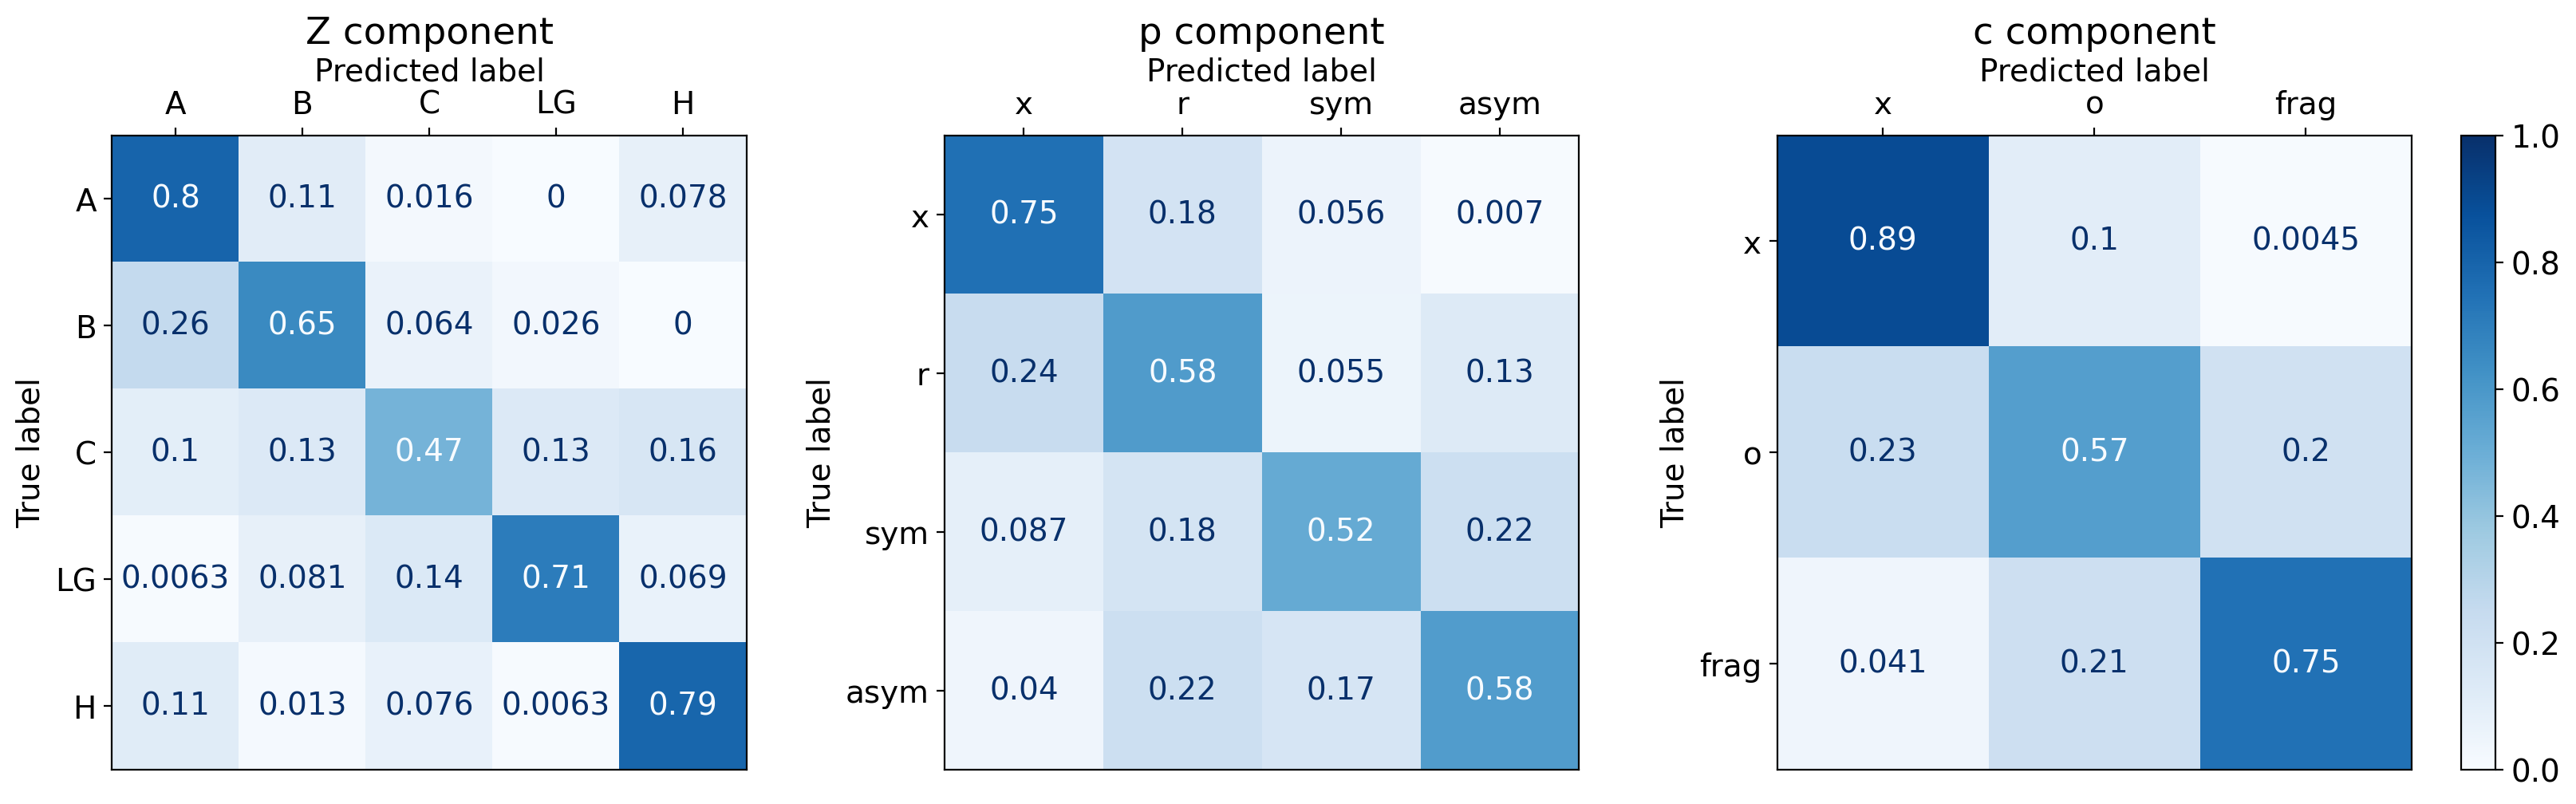

In [12]:
#code for y1
used_c1 = mapper["used_c1"]
if 'SuperGroup' in used_c1.keys():
    used_c1["LG"] = used_c1.pop("SuperGroup")
#     used_c1["SG"] = used_c1.pop("SuperGroup")
    used_c1["H"] = used_c1.pop("H")
    
c1_names  = list(used_c1.keys())
y1_true = federated_y1_pred['GT'].values
y1_pred = federated_y1_pred['pred'].values
conf_mat1 = confusion_matrix(y1_true,y1_pred, normalize='true')


disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_mat1,
                                display_labels=c1_names,
                                )
#code for y2
used_c2 = mapper["used_c2"]
c2_names  = list(used_c2.keys())
y2_true = federated_y2_pred['GT'].values
y2_pred = federated_y2_pred['pred'].values
conf_mat2 = confusion_matrix(y2_true,y2_pred, normalize='true')

disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_mat2,
                                display_labels=c2_names,
)

#code for y3
used_c3 = mapper["used_c3"]
c3_names  = list(used_c3.keys())
y3_true = federated_y3_pred['GT'].values
y3_pred = federated_y3_pred['pred'].values
conf_mat3 = confusion_matrix(y3_true,y3_pred, normalize='true')

disp3 = ConfusionMatrixDisplay(confusion_matrix=conf_mat3,
                                display_labels=c3_names,
)



plt.rcParams.update({'font.size': 14})

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(6*2.6,5) , gridspec_kw={'width_ratios': [33,33,33]} ,dpi=200)
# fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(6*2.6,5) , gridspec_kw={'width_ratios': [33,33,33, 1]} ,dpi=200)
# norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
# cb1 = matplotlib.colorbar.ColorbarBase(ax[3], cmap=plt.cm.Blues,
#                                 norm=norm,
#                                 orientation='vertical')

disp1.plot(ax=ax[0], cmap=plt.cm.Blues, colorbar=False)
# ax[0].imshow(conf_mat1)
ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position('top')
ax[0].set_title('Z component')
for im in ax[0].get_images():               
    im.set_clim(vmin=0,vmax=1)


disp2.plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=False)
ax[1].xaxis.tick_top()
ax[1].xaxis.set_label_position('top')
ax[1].set_title('p component')
for im in ax[1].get_images():               
    im.set_clim(vmin=0,vmax=1)

disp3.plot(ax=ax[2], cmap=plt.cm.Blues, colorbar=False)
ax[2].xaxis.tick_top()
ax[2].xaxis.set_label_position('top')
ax[2].set_title('c component')
for im in ax[2].get_images():               
    im.set_clim(vmin=0,vmax=1)

fig.tight_layout()
ax_cb = fig.add_subplot(144) 
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=plt.cm.Blues,
                                norm=norm,
                                orientation='vertical')
l,b,w,h = ax[2].get_position().bounds
ll,bb,ww,hh = ax_cb.get_position().bounds
ax_cb.set_position([l+w+0.02, b, ww*0.07, h])
fig.show()

# plt.savefig(f"FINAL_20RUNS_AllRevised_BadVoteGlobal_{result_dir}_{k_f}.pdf", format="pdf", bbox_inches="tight")

# Aggregation

We consider any prediction as coming from a single model -> the 20 predictions (ensemble of size 20) for a single sample are considered as 20 different samples -> we concatenate all the predictions.

In [13]:
total_y1_pred.head()

,GT,run_21,run_22,run_23,run_24,run_25,run_26,run_27,run_28,run_29,...,run_32,run_33,run_34,run_35,run_36,run_37,run_38,run_39,run_40,pred
0,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2,0,4,4,4,4,0,0,4,4,0,...,4,4,0,1,0,4,4,4,4,4
3,0,0,0,1,1,1,1,0,0,0,...,1,1,0,1,1,0,1,1,0,1
4,1,1,1,2,1,1,1,1,1,1,...,1,1,2,2,1,1,1,1,1,1


In [14]:
agg_y1_gt = pd.concat([total_y1_pred['GT'].astype(int)]*len(run_dirs))
agg_y1_pred = pd.concat([total_y1_pred[f'run_{id}'].astype(int) for id in run_ids ], axis=0)

print(agg_y1_gt.shape)
print(agg_y1_gt.head())
print(agg_y1_pred.shape)
print(agg_y1_pred.head())

agg_y2_gt = pd.concat([total_y2_pred['GT'].astype(int)]*len(run_dirs))
agg_y2_pred = pd.concat([total_y2_pred[f'run_{id}'].astype(int) for id in run_ids ], axis=0)

print(agg_y2_gt.shape)
print(agg_y2_pred.shape)

agg_y3_gt = pd.concat([total_y3_pred['GT'].astype(int)]*len(run_dirs))
agg_y3_pred = pd.concat([total_y3_pred[f'run_{id}'].astype(int) for id in run_ids ], axis=0)

print(agg_y3_gt.shape)
print(agg_y3_pred.shape)

(11600,)
0    0
1    3
2    0
3    0
4    1
Name: GT, dtype: int64
(11600,)
0    1
1    3
2    4
3    0
4    1
dtype: int64
(11600,)
(11600,)
(11600,)
(11600,)


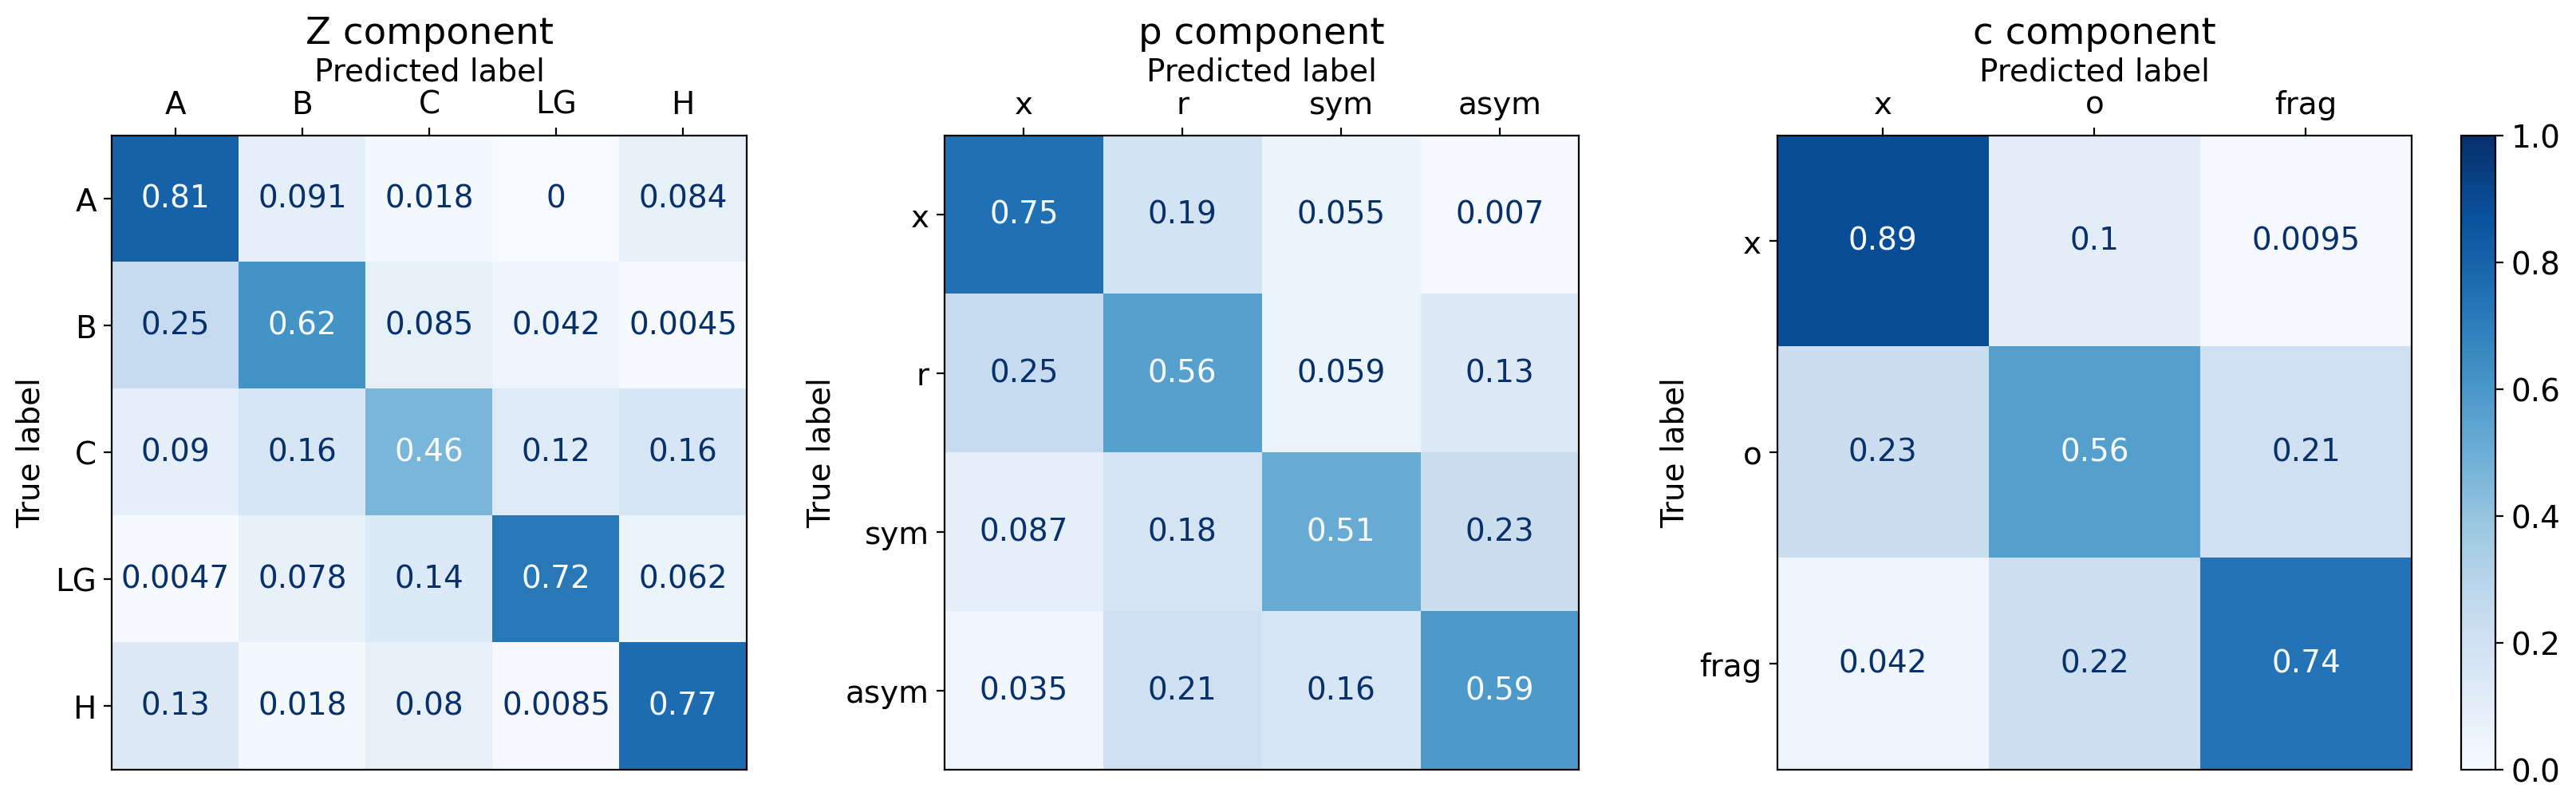

In [15]:
#code for y1
used_c1 = mapper["used_c1"]
c1_names  = list(used_c1.keys())
y1_true = agg_y1_gt.values
y1_pred = agg_y1_pred.values
conf_mat1 = confusion_matrix(y1_true,y1_pred, normalize='true')


disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_mat1,
                                display_labels=c1_names,
                                )
#code for y2
used_c2 = mapper["used_c2"]
c2_names  = list(used_c2.keys())
y2_true = agg_y2_gt.values
y2_pred = agg_y2_pred.values
conf_mat2 = confusion_matrix(y2_true,y2_pred, normalize='true')

disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_mat2,
                                display_labels=c2_names,
)

#code for y3
used_c3 = mapper["used_c3"]
c3_names  = list(used_c3.keys())
y3_true = agg_y3_gt.values
y3_pred = agg_y3_pred.values
conf_mat3 = confusion_matrix(y3_true,y3_pred, normalize='true')

disp3 = ConfusionMatrixDisplay(confusion_matrix=conf_mat3,
                                display_labels=c3_names,
)

                            
# fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(6*2.6,5) , gridspec_kw={'width_ratios': [33,33,33, 1]} ,dpi=200)
# norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
# cb1 = matplotlib.colorbar.ColorbarBase(ax[3], cmap=plt.cm.Blues,
#                                 norm=norm,
#                                 orientation='vertical')
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(6*2.6,5) , gridspec_kw={'width_ratios': [33,33,33]} ,dpi=200)

disp1.plot(ax=ax[0], cmap=plt.cm.Blues, colorbar=False)
# ax[0].imshow(conf_mat1)
ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position('top')
ax[0].set_title('Z component')
for im in ax[0].get_images():               
    im.set_clim(vmin=0,vmax=1)


disp2.plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=False)
ax[1].xaxis.tick_top()
ax[1].xaxis.set_label_position('top')
ax[1].set_title('p component')
for im in ax[1].get_images():               
    im.set_clim(vmin=0,vmax=1)

disp3.plot(ax=ax[2], cmap=plt.cm.Blues, colorbar=False)
ax[2].xaxis.tick_top()
ax[2].xaxis.set_label_position('top')
ax[2].set_title('c component')
for im in ax[2].get_images():               
    im.set_clim(vmin=0,vmax=1)

fig.tight_layout()
ax_cb = fig.add_subplot(144) 
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=plt.cm.Blues,
                                norm=norm,
                                orientation='vertical')
l,b,w,h = ax[2].get_position().bounds
ll,bb,ww,hh = ax_cb.get_position().bounds
ax_cb.set_position([l+w+0.02, b, ww*0.07, h])
fig.show()

# plt.savefig(f"FINAL_20RUNS_All-revised_VoteAggregation_{result_dir}_{k_f}.pdf", format="pdf", bbox_inches="tight")
# plt.savefig(f"VoteAggregation_{kind}.pdf", format="pdf", bbox_inches="tight")


# Erroneous Majority votes

Compute metrics for test samples for which the majority vote was INCORRECT. Need filtering 

In [16]:
# code for y1
# for each row, get the most frequent prediction withouth the GT column and put it in a new column
total_y1_pred['pred'] = total_y1_pred.iloc[:, 1:].mode(axis=1)[0]
total_y1_pred['pred'] = total_y1_pred['pred'].astype(int)
total_y1_pred['GT'] = total_y1_pred['GT'].astype(int)

# create new dataframe with the GT and the pred
federated_y1_pred = total_y1_pred[['GT', 'pred']]


############################################################################################################
#code for y2
# for each row, get the most frequent prediction withouth the GT column and put it in a new column
total_y2_pred['pred'] = total_y2_pred.iloc[:, 1:].mode(axis=1)[0]
total_y2_pred['pred'] = total_y2_pred['pred'].astype(int)
total_y2_pred['GT'] = total_y2_pred['GT'].astype(int)

# create new dataframe with the GT and the pred
federated_y2_pred = total_y2_pred[['GT', 'pred']]

############################################################################################################
#code for y3
# for each row, get the most frequent prediction withouth the GT column and put it in a new column
total_y3_pred['pred'] = total_y3_pred.iloc[:, 1:].mode(axis=1)[0]
total_y3_pred['pred'] = total_y3_pred['pred'].astype(int)
total_y3_pred['GT'] = total_y3_pred['GT'].astype(int)

# create new dataframe with the GT and the pred
federated_y3_pred = total_y3_pred[['GT', 'pred']]

In [17]:
print(federated_y1_pred.shape)
err_federated_y1_pred = federated_y1_pred['GT'] != federated_y1_pred['pred']
# get the corresponding rows in total_y1_pred
y1_fed_errors = total_y1_pred[err_federated_y1_pred]

err_federated_y2_pred = federated_y2_pred['GT'] != federated_y2_pred['pred']
# get the corresponding rows in total_y2_pred
y2_fed_errors = total_y2_pred[err_federated_y2_pred]

err_federated_y3_pred = federated_y3_pred['GT'] != federated_y3_pred['pred']
# get the corresponding rows in total_y3_pred
y3_fed_errors = total_y3_pred[err_federated_y3_pred]

print(y1_fed_errors.shape)
print(y2_fed_errors.shape)
print(y3_fed_errors.shape)

(580, 2)
(183, 22)
(232, 22)
(156, 22)


Now, aggregate Errors

In [18]:
agg_fed_y1_gt = pd.concat([y1_fed_errors['GT'].astype(int)]*len(run_dirs))
agg_fed_y1_pred = pd.concat([y1_fed_errors[f'run_{id}'].astype(int) for id in run_ids ], axis=0)

agg_fed_y2_gt = pd.concat([y2_fed_errors['GT'].astype(int)]*len(run_dirs))
agg_fed_y2_pred = pd.concat([y2_fed_errors[f'run_{id}'].astype(int) for id in run_ids ], axis=0)

agg_fed_y3_gt = pd.concat([y3_fed_errors['GT'].astype(int)]*len(run_dirs))
agg_fed_y3_pred = pd.concat([y3_fed_errors[f'run_{id}'].astype(int) for id in run_ids ], axis=0)


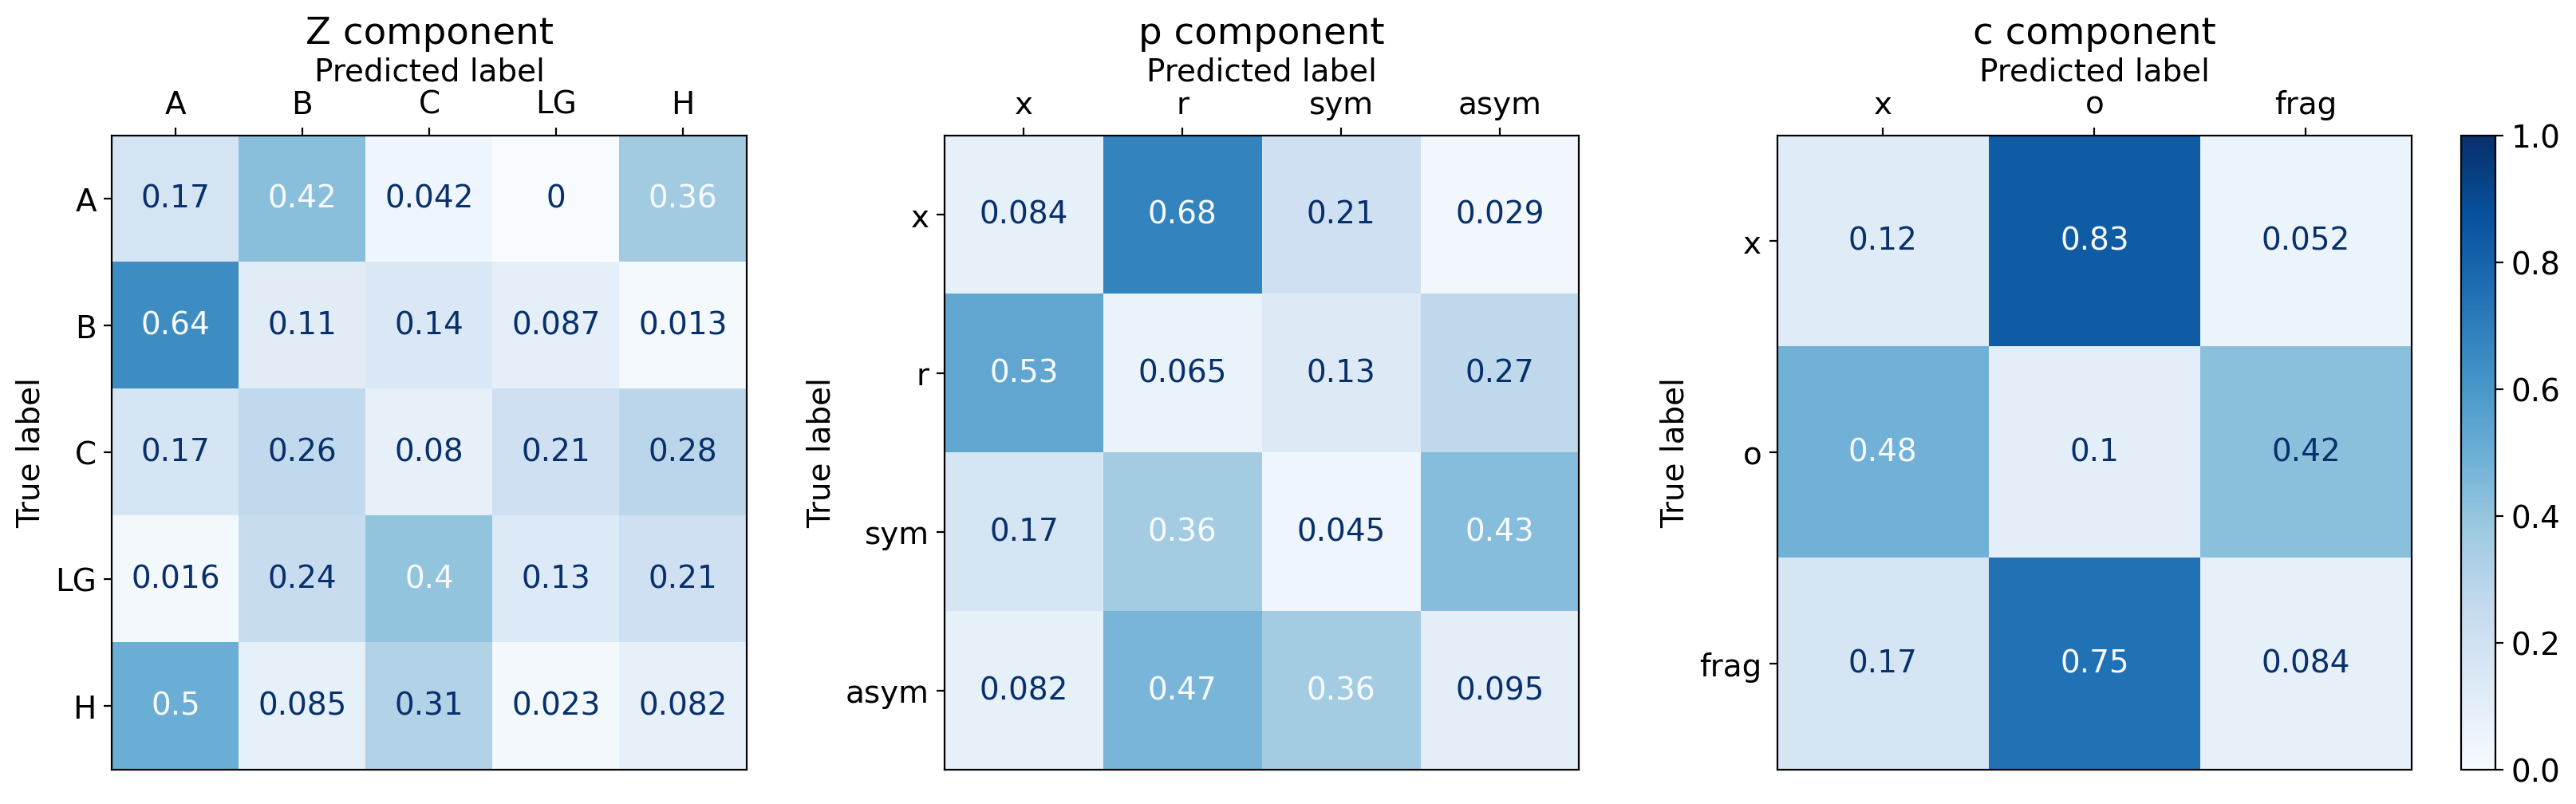

In [19]:
#code for y1
used_c1 = mapper["used_c1"]
c1_names  = list(used_c1.keys())
y1_true = agg_fed_y1_gt.values
y1_pred = agg_fed_y1_pred.values
conf_mat1 = confusion_matrix(y1_true,y1_pred, normalize='true')


disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_mat1,
                                display_labels=c1_names,
                                )
#code for y2
used_c2 = mapper["used_c2"]
c2_names  = list(used_c2.keys())
y2_true = agg_fed_y2_gt.values
y2_pred = agg_fed_y2_pred.values
conf_mat2 = confusion_matrix(y2_true,y2_pred, normalize='true')

disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_mat2,
                                display_labels=c2_names,
)

#code for y3
used_c3 = mapper["used_c3"]
c3_names  = list(used_c3.keys())
y3_true = agg_fed_y3_gt.values
y3_pred = agg_fed_y3_pred.values
conf_mat3 = confusion_matrix(y3_true,y3_pred, normalize='true')

disp3 = ConfusionMatrixDisplay(confusion_matrix=conf_mat3,
                                display_labels=c3_names,
)

                            
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(6*2.6,5) , gridspec_kw={'width_ratios': [33,33,33]} ,dpi=200)


disp1.plot(ax=ax[0], cmap=plt.cm.Blues, colorbar=False)
# ax[0].imshow(conf_mat1)
ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position('top')
ax[0].set_title('Z component')
for im in ax[0].get_images():               
    im.set_clim(vmin=0,vmax=1)


disp2.plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=False)
ax[1].xaxis.tick_top()
ax[1].xaxis.set_label_position('top')
ax[1].set_title('p component')
for im in ax[1].get_images():               
    im.set_clim(vmin=0,vmax=1)

disp3.plot(ax=ax[2], cmap=plt.cm.Blues, colorbar=False)
ax[2].xaxis.tick_top()
ax[2].xaxis.set_label_position('top')
ax[2].set_title('c component')
for im in ax[2].get_images():               
    im.set_clim(vmin=0,vmax=1)

fig.tight_layout()

ax_cb = fig.add_subplot(144) 
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=plt.cm.Blues,
                            norm=norm,
                            orientation='vertical')
l,b,w,h = ax[2].get_position().bounds
ll,bb,ww,hh = ax_cb.get_position().bounds
ax_cb.set_position([l+w+0.02, b, ww*0.07, h])
fig.show()

# plt.savefig(f"FINAL_20RUNS_All-revised_VoteErrors_{result_dir}_{k_f}.pdf", format="pdf", bbox_inches="tight")    

# Correct Majority votes

Compute metrics for test samples for which the majority vote was CORRECT. Need filtering 

In [20]:
print(federated_y1_pred.shape)
corr_federated_y1_pred = federated_y1_pred['GT'] == federated_y1_pred['pred']
# get the corresponding rows in total_y1_pred
y1_fed_correct = total_y1_pred[corr_federated_y1_pred]

corr_federated_y2_pred = federated_y2_pred['GT'] == federated_y2_pred['pred']
# get the corresponding rows in total_y2_pred
y2_fed_correct = total_y2_pred[corr_federated_y2_pred]

corr_federated_y3_pred = federated_y3_pred['GT'] == federated_y3_pred['pred']
# get the corresponding rows in total_y3_pred
y3_fed_correct = total_y3_pred[corr_federated_y3_pred]

print(y1_fed_correct.shape)
print(y2_fed_correct.shape)
print(y3_fed_correct.shape)

(580, 2)
(397, 22)
(348, 22)
(424, 22)


In [21]:
c_agg_fed_y1_gt = pd.concat([y1_fed_correct['GT'].astype(int)]*len(run_dirs))
c_agg_fed_y1_pred = pd.concat([y1_fed_correct[f'run_{id}'].astype(int) for id in run_ids ], axis=0)

c_agg_fed_y2_gt = pd.concat([y2_fed_correct['GT'].astype(int)]*len(run_dirs))
c_agg_fed_y2_pred = pd.concat([y2_fed_correct[f'run_{id}'].astype(int) for id in run_ids ], axis=0)

c_agg_fed_y3_gt = pd.concat([y3_fed_correct['GT'].astype(int)]*len(run_dirs))
c_agg_fed_y3_pred = pd.concat([y3_fed_correct[f'run_{id}'].astype(int) for id in run_ids ], axis=0)


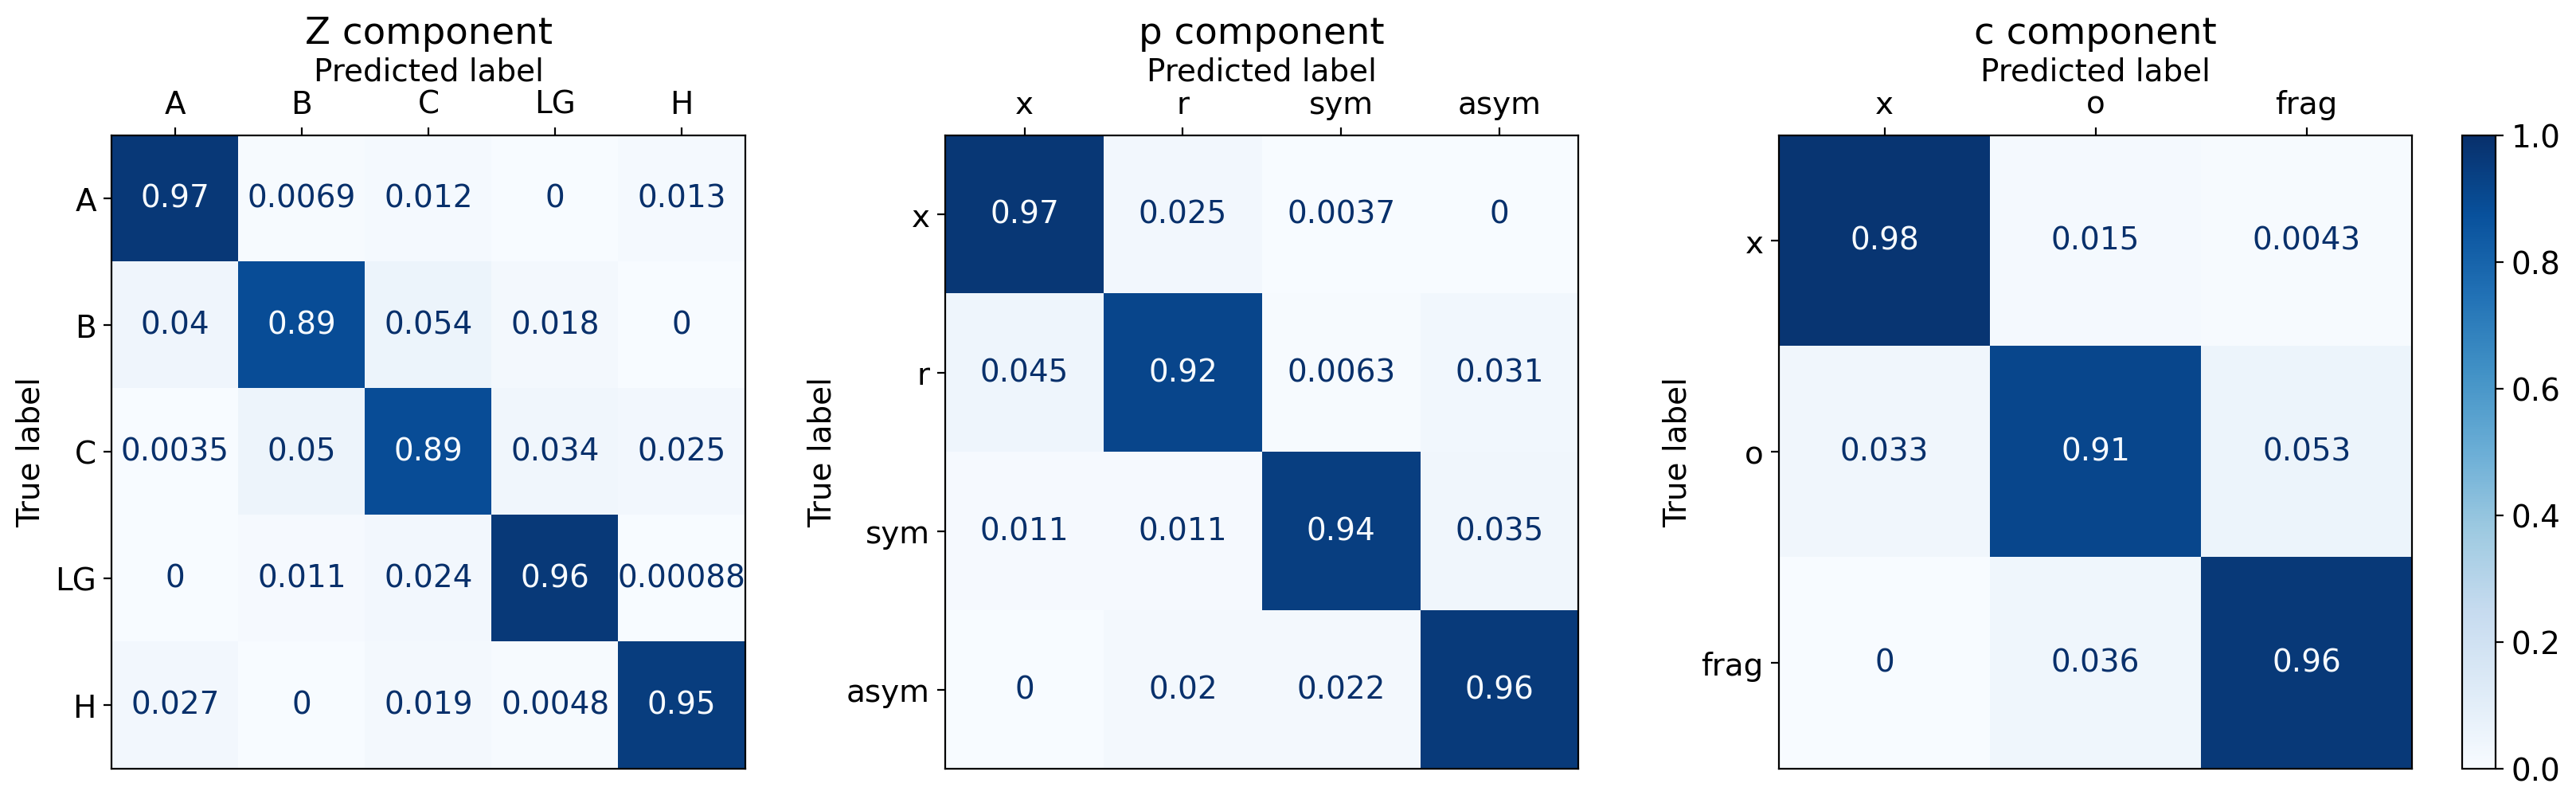

In [22]:
#code for y1
used_c1 = mapper["used_c1"]
c1_names  = list(used_c1.keys())
y1_true = c_agg_fed_y1_gt.values
y1_pred = c_agg_fed_y1_pred.values
conf_mat1 = confusion_matrix(y1_true,y1_pred, normalize='true')


disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_mat1,
                                display_labels=c1_names,
                                )
#code for y2
used_c2 = mapper["used_c2"]
c2_names  = list(used_c2.keys())
y2_true = c_agg_fed_y2_gt.values
y2_pred = c_agg_fed_y2_pred.values
conf_mat2 = confusion_matrix(y2_true,y2_pred, normalize='true')

disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_mat2,
                                display_labels=c2_names,
)

#code for y3
used_c3 = mapper["used_c3"]
c3_names  = list(used_c3.keys())
y3_true = c_agg_fed_y3_gt.values
y3_pred = c_agg_fed_y3_pred.values
conf_mat3 = confusion_matrix(y3_true,y3_pred, normalize='true')

disp3 = ConfusionMatrixDisplay(confusion_matrix=conf_mat3,
                                display_labels=c3_names,
)

                            
                            
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(6*2.6,5) , gridspec_kw={'width_ratios': [33,33,33]} ,dpi=200)

# fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(6*2.6,5) , gridspec_kw={'width_ratios': [33,33,33, 1]} ,dpi=200)
# norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
# cb1 = matplotlib.colorbar.ColorbarBase(ax[3], cmap=plt.cm.Blues,
#                                 norm=norm,
#                                 orientation='vertical')

disp1.plot(ax=ax[0], cmap=plt.cm.Blues, colorbar=False)
# ax[0].imshow(conf_mat1)
ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position('top')
ax[0].set_title('Z component')
for im in ax[0].get_images():               
    im.set_clim(vmin=0,vmax=1)


disp2.plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=False)
ax[1].xaxis.tick_top()
ax[1].xaxis.set_label_position('top')
ax[1].set_title('p component')
for im in ax[1].get_images():               
    im.set_clim(vmin=0,vmax=1)

disp3.plot(ax=ax[2], cmap=plt.cm.Blues, colorbar=False)
ax[2].xaxis.tick_top()
ax[2].xaxis.set_label_position('top')
ax[2].set_title('c component')
for im in ax[2].get_images():               
    im.set_clim(vmin=0,vmax=1)

fig.tight_layout()
ax_cb = fig.add_subplot(144) 
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=plt.cm.Blues,
                                norm=norm,
                                orientation='vertical')
l,b,w,h = ax[2].get_position().bounds
ll,bb,ww,hh = ax_cb.get_position().bounds
ax_cb.set_position([l+w+0.02, b, ww*0.07, h])
fig.show()

# plt.savefig(f"FINAL_20RUNS_All-revised_VoteCorrect_{result_dir}_{k_f}.pdf", format="pdf", bbox_inches="tight")


# Failure cases

In [ ]:
logger = {"_target_": "pytorch_lightning.loggers.CSVLogger",
            "save_dir": 'csv_metrics'
}


# result_dir = 'results_new_dataset'
result_dir = 'results_old_dataset'
# result_dir = 'results_overlap_only'
# result_dir = 'results_filtered'

possible_npy = {'results': 'rebuttal/all_samples.npy',
               'results_old_dataset': 'test/all_samples.npy',
               'results_overlap_only': 'rebuttal_overlap_only/all_samples.npy',
               'results_filtered': 'rebuttal_filtered/all_samples.npy'
              }
use_npy = possible_npy[result_dir]

# print(run_dirs[0].absolute())
print(run_dirs[0].resolve())
r_dir = Path("/home/ucl/elen/nsayez/sunscc/outputs/rebuttal/AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run21")

config, model, dm, trainer = load_from_dir2(
                                    run_path= r_dir.resolve(),
                                    # run_path= run_dirs[0].resolve(),
                                    # run_path= run_dirs[0],
                                    load_trainer=False,
                                    override = [
                                        f'~callbacks.wandb',

#                                         "+callbacks.failurecases={}",
#                                         f"+callbacks.failurecases._target_={failureCallback['_target_']}",
#                                         f"+callbacks.failurecases.focusMcIntoshChar={failureCallback['focusMcIntoshChar']}",
#                                         f"+callbacks.failurecases.focusGTCharClass={failureCallback['focusGTCharClass']}",
#                                         f"+callbacks.failurecases.focusPredCharClass={failureCallback['focusPredCharClass']}",
#                                         f"+callbacks.failurecases.should_norm={failureCallback['should_norm']}",

#                                         'module._target_="sunscc.module.McIntoshClassifier_SuperclassesOLD"',
#                                         'model._target_="sunscc.model.McIntoshClassifierOLD"',

                                        # f'model.input_format="{convert_to_new["input_format"]}"',
                                        # f"+model.input_format.visual={convert_to_new['input_format']['visual']}",
                                        # f"+model.input_format.numeric={convert_to_new['input_format']['numeric']}",

                                        # "+callbacks.explainCallback={}",
                                        # f'+callbacks.explainCallback._target_={explainCallback["_target_"]}',

                                        f'use_npy={use_npy}',
                                        
                                        #remove wandb logger info
                                        f"~logger.0.project",
                                        f"~logger.0.name",
                                        f"~logger.0.resume",
                                        #replace with csv_logger
                                        f"logger.0._target_={logger['_target_']}",
                                        f"++logger.0.save_dir={logger['save_dir']}",

#                                         '~callbacks.wandb',
                                        # f'callbacks.Save_prediction.output_dir={str(run_dir/"predictions")}'
                                        
                                        f"++callbacks.ConfusionMatrix.output_dir={str(run_dir/'results')}",
                                    ]
                                )

In [ ]:
dm.setup()

In [ ]:
#get the test dataloader
test_dl = dm.test_dataloader()

In [ ]:
bs = config.dataset.batch_size
bs

In [ ]:
import matplotlib
from matplotlib import ticker

for k_f, v_f in data_aug_freqs.items():
    freq_run_dirs = [run_dirs[j] for j in v_f]
    
    print(len(freq_run_dirs))
    
    #code for y1
    total_y1_pred = pd.DataFrame()
    for i, run_dir in enumerate(freq_run_dirs):
        run_id = int(str(run_dir)[-2:])
        yt_1 = pd.read_csv(run_dir / result_dir / 'y1.csv' )
        yt_1 = yt_1.loc[:, ~yt_1.columns.str.contains('^Unnamed')] 

        if i == 0:
            total_y1_pred["GT"] = yt_1[['y1_true']]

        total_y1_pred[f'run_{run_id}'] =  yt_1['y1_pred']


    #code for y2
    total_y2_pred = pd.DataFrame()
    for i, run_dir in enumerate(freq_run_dirs):
        run_id = int(str(run_dir)[-2:])
        yt_2 = pd.read_csv(run_dir / result_dir / 'y2.csv' )
        yt_2 = yt_2.loc[:, ~yt_2.columns.str.contains('^Unnamed')] 

        if i == 0:
            total_y2_pred["GT"] = yt_2[['y2_true']]

        total_y2_pred[f'run_{run_id}'] =  yt_2['y2_pred']

    #code for y3
    total_y3_pred = pd.DataFrame()
    for i, run_dir in enumerate(freq_run_dirs):
        run_id = int(str(run_dir)[-2:])
        yt_3 = pd.read_csv(run_dir / result_dir / 'y3.csv' )
        yt_3 = yt_3.loc[:, ~yt_3.columns.str.contains('^Unnamed')] 

        if i == 0:
            total_y3_pred["GT"] = yt_3[['y3_true']]

        total_y3_pred[f'run_{run_id}'] =  yt_3['y3_pred']
        
    ###############################################################################################################
        
    # code for y1
    # for each row, get the most frequent prediction withouth the GT column and put it in a new column
    total_y1_pred['pred'] = total_y1_pred.iloc[:, 1:].mode(axis=1)[0]
    total_y1_pred['pred'] = total_y1_pred['pred'].astype(int)
    total_y1_pred['GT'] = total_y1_pred['GT'].astype(int)

    # create new dataframe with the GT and the pred
    federated_y1_pred = total_y1_pred[['GT', 'pred']]

    
    ##################################
    #code for y2
    # for each row, get the most frequent prediction withouth the GT column and put it in a new column
    total_y2_pred['pred'] = total_y2_pred.iloc[:, 1:].mode(axis=1)[0]
    total_y2_pred['pred'] = total_y2_pred['pred'].astype(int)
    total_y2_pred['GT'] = total_y2_pred['GT'].astype(int)

    # create new dataframe with the GT and the pred
    federated_y2_pred = total_y2_pred[['GT', 'pred']]

    ###################################
    #code for y3
    # for each row, get the most frequent prediction withouth the GT column and put it in a new column
    total_y3_pred['pred'] = total_y3_pred.iloc[:, 1:].mode(axis=1)[0]
    total_y3_pred['pred'] = total_y3_pred['pred'].astype(int)
    total_y3_pred['GT'] = total_y3_pred['GT'].astype(int)

    # create new dataframe with the GT and the pred
    federated_y3_pred = total_y3_pred[['GT', 'pred']]
    
    
    
    print(total_y2_pred.shape)
    
    ######################################################################################################
    

    for batch_idx, batch in enumerate(test_dl):
        print(batch_idx)
        # print()
        # print()
        # print()
        # print()
        # print()

        # print(batch.keys())

        # print()
        # print()
        # print()
        # print()
        # print()
        img_indexes = (batch_idx * bs) + np.array(range(batch['image'].shape[0]))
        print(img_indexes)

        # print(batch.keys())
        # print(batch['image'].shape)

        # print(batch['class1'])

        # print(total_y1_pred['GT'][img_indexes])
        # print(total_y1_pred['pred'][img_indexes])

        cur_gt_1 = total_y1_pred['GT'][img_indexes]
        cur_pred_1 = total_y1_pred['pred'][img_indexes]
        cur_runPreds_1 = total_y1_pred[[f'run_{id}' for id in run_ids]].iloc[img_indexes]
        cur_gt_2 = total_y2_pred['GT'][img_indexes]
        cur_pred_2 = total_y2_pred['pred'][img_indexes]
        cur_runPreds_2 = total_y2_pred[[f'run_{id}' for id in run_ids]].iloc[img_indexes]
        cur_gt_3 = total_y3_pred['GT'][img_indexes]
        cur_pred_3 = total_y3_pred['pred'][img_indexes]
        cur_runPreds_3 = total_y3_pred[[f'run_{id}' for id in run_ids]].iloc[img_indexes]

        c1,c2,c3 = batch['class1'], batch['class2'], batch['class3']
        gt = {'class1':c1.squeeze(1),'class2':c2.squeeze(1),'class3':c3.squeeze(1)}


        pred =  {'class1':cur_pred_1.values,'class2':cur_pred_2.values,'class3':cur_pred_3.values}

    #     incorrect_idx = np.where(cur_gt_1 != cur_pred_1)[0]
        incorrect_idx = np.where(cur_gt_1 != cur_pred_1)[0]
        print(incorrect_idx)


    #     for j in enumerate(incorrect_idx):
        for j in incorrect_idx:
            # show the batch['image'] at indexes where the GT and pred are different
            img = batch['image'][j]
            img = torch.flip(img,[0,1])
            img = 3500*img

            msk = batch['confidence_map'][j]
            msk = torch.flip(msk,[0,1])
            grp_msk = batch['group_confidence_map'][j]
            grp_msk = torch.flip(grp_msk,[0,1])
            
    #         print(img.shape)
    #         images_to_show = batch['image'][incorrect_idx]

            g_C1 = str(int(gt['class1'][j].cpu().numpy()))
            g_C1 = inverted_mapper['inv_c1'][g_C1]
            g_C1 = 'SG' if g_C1 == 'SuperGroup' else g_C1
            g_C2 = str(int(gt['class2'][j].cpu().numpy()))
            g_C2 = inverted_mapper['inv_c2'][g_C2]
            g_C3 = str(int(gt['class3'][j].cpu().numpy()))
            g_C3 = inverted_mapper['inv_c3'][g_C3]

            pred_C1 = str(pred['class1'][j])
            pred_C1 = inverted_mapper['inv_c1'][pred_C1] 
            pred_C1 = 'SG' if pred_C1 == 'SuperGroup' else pred_C1
            pred_C2 = str(pred['class2'][j])
            pred_C2 = inverted_mapper['inv_c2'][pred_C2] 
            pred_C3 = str(pred['class3'][j])
            pred_C3 = inverted_mapper['inv_c3'][pred_C3]

            strMcIntosh = f'{g_C1}_{g_C2}_{g_C3}'
            strMcIntosh_hat = f'{pred_C1}_{pred_C2}_{pred_C3}'
    #         print(f"GT: {strMcIntosh}\nPred:{strMcIntosh_hat}")

            # title = f"GT: {inverted_mapper['inv_c1'][str(cur_gt[incorrect_idx[j]])]}\n Pred: {inverted_mapper['inv_c1'][str(cur_pred[incorrect_idx[j]])]}"

            normalize = matplotlib.colors.Normalize(vmin=0, vmax=4000)

            f = plt.figure(figsize=(6,4))
            a = f.add_subplot(121)
            a.imshow(img, cmap='gray', interpolation='none', vmin=0, vmax=4000)
            # a.imshow(3500*img, cmap='gray', norm=normalize, interpolation='none')
            a.set_title(f"{batch['group_name'][j]}")
            a.set_xlabel(f"GT: {strMcIntosh}    Pred:{strMcIntosh_hat}")
            a.set_xticks([])
            a.set_yticks([])
            
            # c = f.add_subplot(121)
            # c.imshow(msk, cmap='gray', norm=normalize, interpolation='none', alpha=.5)
            # grp_msk_tmp =  grp_msk.clone()
            # grp_msk_tmp[grp_msk_tmp==0] = torch.nan
            # c.imshow(grp_msk, cmap='jet', interpolation='none', alpha=.5)
            # c.imshow(grp_msk_tmp, cmap='jet', interpolation='none', alpha=.5)
            # c.set_xticks([])
            # c.set_yticks([])

            b = f.add_subplot(122)
            sns.countplot(x=cur_runPreds_1.iloc[j], ax=b, order=range(0, len(used_c1)))
            b.set_ylabel('')
            b.set_xlabel('')
            b.xaxis.set_major_locator(ticker.FixedLocator(range(0, len(used_c1))))
            b.set_xticks(range(0, len(used_c1)))
    #         b.set_xticklabels(list(used_c1.keys()), rotation=90)

            b.set_xticklabels(list(used_c1.keys()))
            b.yaxis.set_major_locator(ticker.FixedLocator(range(0,len(run_dirs)+1,2)))
            b.set_yticklabels(range(0,len(run_dirs)+1,2))
            b.set_ylim([0, len(run_dirs)+1])
    #         b.set_title(f'Confusion Histogram for sample')
            b.set_title(f'Votes')

    #         plt.axis('off')

    #         print(cur_gt_1)
    #         print(error_figures_per_class[inverted_mapper['inv_c1'][str(cur_gt_1[j])]])
            cl = inverted_mapper['inv_c1'][str(cur_gt_1[(batch_idx * bs)+j])]
            if cl == "SuperGroup":
                cl="LG"
                # cl="SG"

            err_kind = f'{cl}to{pred_C1}'

            out_dir = os.path.join('./Federated_errors', cl, err_kind)
            if not os.path.isdir(out_dir):
                os.makedirs(out_dir)
            out_file = os.path.join(out_dir, batch['group_name'][j])
            f.tight_layout()    
    #         f.savefig(out_file+".pdf", format="pdf", bbox_inches="tight") 
    #         plt.close()


#             f2 = plt.figure(figsize=(4.5,4))
#             a = f2.add_subplot(111)
#             a.imshow(3500*img, cmap='gray', norm=normalize, interpolation='none')
#             a.set_title(f"{batch['group_name'][j]}")
#             a.set_xlabel(f"GT: {strMcIntosh}    Pred:{strMcIntosh_hat}")
#             a.set_xticks([])
#             a.set_yticks([])
#             out_dir = os.path.join('./Federated_errors_noVotes', cl, err_kind)
#             if not os.path.isdir(out_dir):
#                 os.makedirs(out_dir)
#             out_file = os.path.join(out_dir, batch['group_name'][j])
#             f2.tight_layout()    
#     #         f2.savefig(out_file+".pdf", format="pdf", bbox_inches="tight") 
#     #         plt.close()


        break

    break




In [ ]:
import matplotlib

for batch_idx, batch in enumerate(test_dl):
    print(batch_idx)
    img_indexes = (batch_idx * bs) + np.array(range(batch['image'].shape[0]))
    print(img_indexes)
    
    # print(batch.keys())
    # print(batch['image'].shape)

    # print(batch['class1'])

    # print(total_y1_pred['GT'][img_indexes])
    # print(total_y1_pred['pred'][img_indexes])

    cur_gt_1 = total_y1_pred['GT'][img_indexes]
    cur_pred_1 = total_y1_pred['pred'][img_indexes]
    cur_runPreds_1 = total_y1_pred[[f'run_{id}' for id in run_ids]].iloc[img_indexes]
    cur_gt_2 = total_y2_pred['GT'][img_indexes]
    cur_pred_2 = total_y2_pred['pred'][img_indexes]
    cur_runPreds_2 = total_y2_pred[[f'run_{id}' for id in run_ids]].iloc[img_indexes]
    cur_gt_3 = total_y3_pred['GT'][img_indexes]
    cur_pred_3 = total_y3_pred['pred'][img_indexes]
    cur_runPreds_3 = total_y3_pred[[f'run_{id}' for id in run_ids]].iloc[img_indexes]
    
    c1,c2,c3 = batch['class1'], batch['class2'], batch['class3']
    gt = {'class1':c1.squeeze(1),'class2':c2.squeeze(1),'class3':c3.squeeze(1)}


    pred =  {'class1':cur_pred_1.values,'class2':cur_pred_2.values,'class3':cur_pred_3.values}

#     incorrect_idx = np.where(cur_gt_1 != cur_pred_1)[0]
    incorrect_idx = np.where(cur_gt_1 != cur_pred_1)[0]
    print(incorrect_idx)
    
    
#     for j in enumerate(incorrect_idx):
    for j in incorrect_idx:
        # show the batch['image'] at indexes where the GT and pred are different
        img = batch['image'][j]
        img = torch.flip(img,[0,1])
#         print(img.shape)
#         images_to_show = batch['image'][incorrect_idx]

        g_C1 = str(int(gt['class1'][j].cpu().numpy()))
        g_C1 = inverted_mapper['inv_c1'][g_C1]
        g_C1 = 'SG' if g_C1 == 'SuperGroup' else g_C1
        g_C2 = str(int(gt['class2'][j].cpu().numpy()))
        g_C2 = inverted_mapper['inv_c2'][g_C2]
        g_C3 = str(int(gt['class3'][j].cpu().numpy()))
        g_C3 = inverted_mapper['inv_c3'][g_C3]

        pred_C1 = str(pred['class1'][j])
        pred_C1 = inverted_mapper['inv_c1'][pred_C1] 
        pred_C1 = 'SG' if pred_C1 == 'SuperGroup' else pred_C1
        pred_C2 = str(pred['class2'][j])
        pred_C2 = inverted_mapper['inv_c2'][pred_C2] 
        pred_C3 = str(pred['class3'][j])
        pred_C3 = inverted_mapper['inv_c3'][pred_C3]
        
        strMcIntosh = f'{g_C1}_{g_C2}_{g_C3}'
        strMcIntosh_hat = f'{pred_C1}_{pred_C2}_{pred_C3}'
#         print(f"GT: {strMcIntosh}\nPred:{strMcIntosh_hat}")
        
        # title = f"GT: {inverted_mapper['inv_c1'][str(cur_gt[incorrect_idx[j]])]}\n Pred: {inverted_mapper['inv_c1'][str(cur_pred[incorrect_idx[j]])]}"
        
        normalize = matplotlib.colors.Normalize(vmin=0, vmax=4000)
        
        f = plt.figure(figsize=(8,4))
        a = f.add_subplot(121)
        a.imshow(3500*img, cmap='gray', norm=normalize, interpolation='none')
        a.set_title(f"{batch['group_name'][j]}")
        a.set_xlabel(f"GT: {strMcIntosh}    Pred:{strMcIntosh_hat}")
        a.set_xticks([])
        a.set_yticks([])
        
        b = f.add_subplot(122)
        sns.countplot(x=cur_runPreds_1.iloc[j], ax=b, order=range(0, len(used_c1)))
        b.set_ylabel('')
        b.set_xlabel('')
        b.xaxis.set_major_locator(ticker.FixedLocator(range(0, len(used_c1))))
        b.set_xticks(range(0, len(used_c1)))
#         b.set_xticklabels(list(used_c1.keys()), rotation=90)
        b.set_xticklabels(list(used_c1.keys()))
        b.yaxis.set_major_locator(ticker.FixedLocator(range(0,len(run_dirs)+1,2)))
        b.set_yticklabels(range(0,len(run_dirs)+1,2))
        b.set_ylim([0, len(run_dirs)+1])
#         b.set_title(f'Confusion Histogram for sample')
        b.set_title(f'Votes')

#         plt.axis('off')

#         print(cur_gt_1)
#         print(error_figures_per_class[inverted_mapper['inv_c1'][str(cur_gt_1[j])]])
        cl = inverted_mapper['inv_c1'][str(cur_gt_1[(batch_idx * bs)+j])]
        if cl == "SuperGroup":
            cl="SG"
            
        err_kind = f'{cl}to{pred_C1}'
            
        out_dir = os.path.join('./Federated_errors', cl, err_kind)
        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)
        out_file = os.path.join(out_dir, batch['group_name'][j])
        f.tight_layout()    
        f.savefig(out_file+".pdf", format="pdf", bbox_inches="tight") 
        plt.close()

        f2 = plt.figure(figsize=(4.5,4))
        a = f2.add_subplot(111)
        a.imshow(3500*img, cmap='gray', norm=normalize, interpolation='none')
        a.set_title(f"{batch['group_name'][j]}")
        a.set_xlabel(f"GT: {strMcIntosh}    Pred:{strMcIntosh_hat}")
        a.set_xticks([])
        a.set_yticks([])
        out_dir = os.path.join('./Federated_errors_noVotes', cl, err_kind)
        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)
        out_file = os.path.join(out_dir, batch['group_name'][j])
        f2.tight_layout()    
        f2.savefig(out_file+".pdf", format="pdf", bbox_inches="tight") 
        plt.close()
            
    
#     break



        
        

In [ ]:
from skimage.io import imread
import glob
i

error_figures_per_class = {k:[] for k in mapper["used_c1"].keys()}
print(error_figures_per_class)



for k in error_figures_per_class:
    print("#####################   ",k)
    
    err_kinds = sorted(glob.glob(os.path.join('./Federated_errors', k,'*')))
                       
    for kind in err_kinds:
        print(kind)
        errs = sorted(glob.glob(os.path.join(kind,'*.png')))
    
        for err in errs:
            im = imread(err)
            plt.figure(figsize=(8,4))
            ax = plt.subplot(111)
            ax.imshow(im)
            ax.axis('off')
            plt.show()
            
            
#     errs = sorted(glob.glob(os.path.join('./Federated_errors',k,'*.png')))
#     for err in errs:
# #         print(err)
#         im = imread(err)
#         plt.figure(figsize=(4,4))
#         ax = plt.subplot(111)
#         ax.imshow(im)
#         ax.axis('off')
#         plt.show()
        

In [ ]:
from skimage.io import imread
import glob

error_figures_per_class = {k:[] for k in mapper["used_c1"].keys()}
print(error_figures_per_class)



for k in error_figures_per_class:
    print("#####################   ",k)
    
    err_kinds = sorted(glob.glob(os.path.join('./Federated_errors_noVotes', k,'*')))
                       
    for kind in err_kinds:
        print(kind)
        errs = sorted(glob.glob(os.path.join(kind,'*.png')))
    
        for err in errs:
            im = imread(err)
            plt.figure(figsize=(4.5,4))
            ax = plt.subplot(111)
            ax.imshow(im)
            ax.axis('off')
            plt.show()
            
            
#     errs = sorted(glob.glob(os.path.join('./Federated_errors',k,'*.png')))
#     for err in errs:
# #         print(err)
#         im = imread(err)
#         plt.figure(figsize=(4,4))
#         ax = plt.subplot(111)
#         ax.imshow(im)
#         ax.axis('off')
#         plt.show()
        